In [1290]:
#import re
#from pyspark.sql import Row
#from pyspark.ml.feature import MinHashLSH, CountVectorizer
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import col, count, desc, avg, min, max, from_unixtime, unix_timestamp, date_format, first, udf, substring, element_at
#from pyspark.sql.types import StringType,IntegerType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#!pip install transformers

import transformers
from transformers import set_seed
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
set_seed(42)

import math

from pandas import DataFrame
from pandas import concat
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization

seed_value = 42
import random
random.seed(seed_value)
np.random.seed(seed_value)


import torch
from scipy.special import softmax

import tensorflow as tf
tf.random.set_seed(seed_value)

# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
#https://huggingface.co/ProsusAI/finbert
# https://huggingface.co/nickmuchi/sec-bert-finetuned-finance-classification
# https://huggingface.co/SamLowe/roberta-base-go_emotions



# Data

## BTC Price History -- df_btc

In [698]:
# read in historical_bitcoin_data_2018_2023.csv
df_btc_raw = pd.read_csv('historical_bitcoin_data_2018_2023.csv')

# convert created_utx in unix to datetime
df_btc_raw['kline_close_time'] = pd.to_datetime(df_btc_raw['kline_close_time'], unit='ms')
# round kline_close_time to the nearest hour
df_btc_raw['kline_close_time'] = df_btc_raw['kline_close_time'].dt.round('H')
df_btc_raw.sort_values(by='kline_close_time', inplace=True)
# rename kline_close_time to timestamp
df_btc_raw.rename(columns={'kline_close_time': 'timestamp'}, inplace=True)

# create fields
df_btc_raw['taker_sell_base_asset_volume'] = df_btc_raw['volume'] - df_btc_raw['taker_buy_base_asset_volume']
df_btc_raw['taker_sell_quote_asset_volume'] = df_btc_raw['taker_sell_base_asset_volume'] * df_btc_raw['close_price']

# rename long fields
df_btc_raw.rename(columns={'taker_buy_base_asset_volume': 'buy_volume',
                           'taker_buy_quote_asset_volume': 'buy_notional',
                           'taker_sell_base_asset_volume': 'sell_volume',
                           'taker_sell_quote_asset_volume': 'sell_notional'
                           }, inplace=True)


# reset index
df_btc_raw.reset_index(drop=True, inplace=True)

# price returns -- FORWARD LOOKING***
# i.e. 2018-01-01 01:00:00 ret_1_h = 2018-01-01 02:00:00 / 2018-01-01 01:00:00 - 1
intervals = [1, 6, 1*24, 2*24, 3*24, 4*24, 5*24, 10*24]
for interval in intervals:
    df_btc_raw[f'ret_fwd_{interval}_h'] = df_btc_raw['close_price'].pct_change(periods=interval)
    df_btc_raw[f'ret_fwd_{interval}_h'] = df_btc_raw[f'ret_fwd_{interval}_h'].shift(-interval)
    
    # price returns -- BACKWARD LOOKING***
    df_btc_raw[f'ret_past_{interval}_h'] = df_btc_raw['close_price'].pct_change(periods=interval)
    
    # volume sum -- BACKWARD LOOKING
    # calculate sum over the past x intervals
    df_btc_raw[f'vol_{interval}_h'] = df_btc_raw['volume'].rolling(interval).sum()
    df_btc_raw[f'volBuy_{interval}_h'] = df_btc_raw['buy_volume'].rolling(interval).sum()
    df_btc_raw[f'volSell_{interval}_h'] = df_btc_raw['sell_volume'].rolling(interval).sum()

    # trdCnt sum -- BACKWARD LOOKING
    df_btc_raw[f'trdCnt_{interval}_h'] = df_btc_raw['num_of_trades'].rolling(interval).sum()

    # volatility -- BACKWARD LOOKING
    df_btc_raw[f'volatility_{interval}_h'] = df_btc_raw['close_price'].pct_change().rolling(interval).std()
    # volatility, but using exponential moving average
    """
    EMA decay factor = 2/(span+1)
    at time t, sample weight = (1 - 2/(span + 1))**t
    for wieght = 1/2, t = ln(2)*span / ln(2/(span+1))
    when span is large, weight = 1/2 at time t = 0.693*span
    when span is large, weight = 1/e^2 = 0.135 at time t = span
    """    
    df_btc_raw[f'volatilityEMA_{interval}_h'] = df_btc_raw['close_price'].pct_change().ewm(span=interval).std()


df_btc = df_btc_raw[['timestamp',
                    'close_price',
                    'ret_past_1_h', 'ret_past_6_h', 'ret_past_24_h', 'ret_past_48_h', 'ret_past_72_h', 'ret_past_96_h', 'ret_past_120_h', 'ret_past_240_h',
                    #'volume', 'buy_volume', 'sell_volume',
                    'vol_1_h', 'vol_6_h', 'vol_24_h', 'vol_48_h', 'vol_72_h', 'vol_96_h', 'vol_120_h', 'vol_240_h',
                    'volBuy_1_h', 'volBuy_6_h', 'volBuy_24_h', 'volBuy_48_h', 'volBuy_72_h', 'volBuy_96_h', 'volBuy_120_h', 'volBuy_240_h',
                    'volSell_1_h', 'volSell_6_h', 'volSell_24_h', 'volSell_48_h', 'volSell_72_h', 'volSell_96_h', 'volSell_120_h', 'volSell_240_h',
                    'trdCnt_1_h', 'trdCnt_6_h', 'trdCnt_24_h', 'trdCnt_48_h', 'trdCnt_72_h', 'trdCnt_96_h', 'trdCnt_120_h', 'trdCnt_240_h',
                    'volatility_1_h', 'volatility_6_h', 'volatility_24_h', 'volatility_48_h', 'volatility_72_h', 'volatility_96_h', 'volatility_120_h', 'volatility_240_h',
                    'volatilityEMA_1_h', 'volatilityEMA_6_h', 'volatilityEMA_24_h', 'volatilityEMA_48_h', 'volatilityEMA_72_h', 'volatilityEMA_96_h', 'volatilityEMA_120_h', 'volatilityEMA_240_h',
                    'ret_fwd_1_h', 'ret_fwd_6_h', 'ret_fwd_24_h', 'ret_fwd_48_h', 'ret_fwd_72_h', 'ret_fwd_96_h', 'ret_fwd_120_h', 'ret_fwd_240_h'
                    ]].copy()

# create timestamp : ret_fwd dictionaries
ret_fwd_1_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_1_h']))
ret_fwd_6_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_6_h']))
ret_fwd_24_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_24_h']))
ret_fwd_48_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_48_h']))
ret_fwd_72_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_72_h']))
ret_fwd_96_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_96_h']))
ret_fwd_120_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_120_h']))
ret_fwd_240_dict = dict(zip(df_btc['timestamp'], df_btc['ret_fwd_240_h']))

df_btc.tail(5)

/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/1985457351.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_btc_raw['kline_close_time'] = df_btc_raw['kline_close_time'].dt.round('H')


,timestamp,close_price,ret_past_1_h,ret_past_6_h,ret_past_24_h,ret_past_48_h,ret_past_72_h,ret_past_96_h,ret_past_120_h,ret_past_240_h,...,volatilityEMA_120_h,volatilityEMA_240_h,ret_fwd_1_h,ret_fwd_6_h,ret_fwd_24_h,ret_fwd_48_h,ret_fwd_72_h,ret_fwd_96_h,ret_fwd_120_h,ret_fwd_240_h
51723,2023-12-31 20:00:00,42619.04,-0.000883,0.003779,0.006088,0.011932,0.000197,-0.012404,0.012110,-0.022248,...,0.003648,0.003831,-0.001432,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51724,2023-12-31 21:00:00,42558.01,-0.001432,0.000730,0.006481,0.012635,0.001213,-0.020424,0.010036,-0.028285,...,0.003623,0.003817,-0.000876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51725,2023-12-31 22:00:00,42520.72,-0.000876,0.001497,0.005097,0.013938,0.001572,-0.019496,0.004305,-0.033509,...,0.003595,0.003802,-0.006181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51726,2023-12-31 23:00:00,42257.88,-0.006181,-0.007856,0.002970,0.011898,-0.008638,-0.024604,-0.004994,-0.038489,...,0.003652,0.003827,0.000608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51727,2024-01-01 00:00:00,42283.58,0.000608,-0.007806,0.003401,0.005150,-0.006583,-0.026371,-0.005301,-0.035982,...,0.003623,0.003812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [700]:
## CATEGORICAL VARIABLE FOR RET FWD

df_btc_signal = df_btc.copy()

# signal threshold
ret_thresh = 0.005 # 0.5%
# where ret_fwd columns are > +ret_thresh, set value to +1; < -ret_thresh, set value to -1; else 0
for col in df_btc_signal.columns:
    if 'ret_fwd_' in col:
        df_btc_signal[col] = np.where(df_btc_signal[col] > ret_thresh, 1, np.where(df_btc_signal[col] < -ret_thresh, -1, 0))

df_btc_signal



,timestamp,close_price,ret_past_1_h,ret_past_6_h,ret_past_24_h,ret_past_48_h,ret_past_72_h,ret_past_96_h,ret_past_120_h,ret_past_240_h,...,volatilityEMA_120_h,volatilityEMA_240_h,ret_fwd_1_h,ret_fwd_6_h,ret_fwd_24_h,ret_fwd_48_h,ret_fwd_72_h,ret_fwd_96_h,ret_fwd_120_h,ret_fwd_240_h
0,2018-01-01 01:00:00,13529.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1,1,1,1,1,1,1,1
1,2018-01-01 02:00:00,13203.06,-0.024093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,1,1,1,1,1
2,2018-01-01 03:00:00,13330.18,0.009628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.023844,0.023844,1,1,1,1,1,1,1,-1
3,2018-01-01 04:00:00,13410.03,0.005990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018423,0.018466,1,1,0,1,1,1,1,-1
4,2018-01-01 05:00:00,13601.01,0.014242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017233,0.017294,0,0,-1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51723,2023-12-31 20:00:00,42619.04,-0.000883,0.003779,0.006088,0.011932,0.000197,-0.012404,0.012110,-0.022248,...,0.003648,0.003831,0,0,0,0,0,0,0,0
51724,2023-12-31 21:00:00,42558.01,-0.001432,0.000730,0.006481,0.012635,0.001213,-0.020424,0.010036,-0.028285,...,0.003623,0.003817,0,0,0,0,0,0,0,0
51725,2023-12-31 22:00:00,42520.72,-0.000876,0.001497,0.005097,0.013938,0.001572,-0.019496,0.004305,-0.033509,...,0.003595,0.003802,-1,0,0,0,0,0,0,0
51726,2023-12-31 23:00:00,42257.88,-0.006181,-0.007856,0.002970,0.011898,-0.008638,-0.024604,-0.004994,-0.038489,...,0.003652,0.003827,0,0,0,0,0,0,0,0


## Reddit: Submissions, Comments

Raw Reddit data of Submissions and Comments. Comes from Data Cleaning output and contains cleaned selftext, indiviual sentiment scores, individual relevancy and inference scores.

In [120]:
#data_path_sub = "gcs/stonkgo/reddit-data-bitcoin/filtered_data/submissions/submissions_06-30-12-31-2023"
#data_path_sub = "submissions_06-30-12-31-2023"
#data_path_sub = "submissions_09-30-12-31-2023"
data_path_sub = "sentiments_cleaned"
df_sub_raw = pd.read_parquet(data_path_sub)
#print(df_sub_raw.dtypes)

In [121]:

def enhance_reddit_submissions(df):
    """ NOTES
    link_flair_text --> one of these items: array(['None', 'price', 'off topic', 'repetitive',
       "there's already a thread & this has nothing to do with Bitcoin",
       'low quality', 'bitcoinmarkets', 'meta', 'non-english',
       'financial advice', 'scam', 'mining', 'see sticky', 'no context',
       'trading', 'begging', 'spam', 'comment as submission', 'meme',
       'not yet', 'misleading', 'altcoin', 'duplicate', 'bad link',
       'referral', 'customer support', 'do not encourage brigading'],

    score = ups; downs are all 0 in this dataset (not useful)
    """
    # filter out spam

    # drop nas
    df.dropna(subset=["selftext"], inplace=True)
    df.selftext = df.selftext.astype("string")

    # rename columns
    df.rename(columns={'id': 'id_sub'}, inplace=True)
    df.submission_id = df.id_sub.astype("string")
    df.rename(columns={'name': 'id_sub_t'}, inplace=True)

    # add selftext truncated to 514 characters
    df['selftext_trunc514'] = df['selftext'].apply(lambda x: x[:514])

    # calc original length of text
    df['length'] = df['selftext'].apply(len)
    df['length_trunc514'] = df['selftext_trunc514'].apply(len)

    # convert created_utx in unix to datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
    # rename as 'timestamp'
    df.rename(columns={'created_utc': 'timestamp'}, inplace=True)
    # retrieved on
    df['retrieved_on'] = pd.to_datetime(df['retrieved_on'], unit='s')
    # convert to EST, adjusting for daylight savings 
    #df['created_utc'] = df['created_utc'] - pd.Timedelta(hours=5) - pd.Timedelta(hours=1)

    # convert from object to float
    df['num_comments'] = df['num_comments'].fillna(0).astype(float)
    df['num_crossposts'] = df['num_crossposts'].fillna(0).astype(float)
    df['subreddit_subscribers'] = df['subreddit_subscribers'].fillna(0).astype(float)
    df['total_awards_received'] = df['total_awards_received'].fillna(0).astype(float)
    ##
    df['score'] = df['score'].fillna(0).astype(float)
    df['upvote_ratio'] = df['upvote_ratio'].astype(float)
    df['ups'] = df['ups'].astype(float)
    df['downs'] = df['downs'].astype(float)

    # RELEVANCY SCORE -- dummy
    df['relevancy_score'] = 1

    # VOTE SCORE
    # floor at 0
    df['score'] = np.where(df['score'] < 0, 0, df['score'])

    # drop columns 
    # name is t3_ + submission_id
    df.drop(columns=['ups','downs'], inplace=True) # downs is always 0
    #df['all_awardings'] = df['all_awardings'].fillna(0).astype(float)

    # drop rows
    # drop if 'author' contains 'rBitcoinMod'
    df = df[~df['author'].str.contains('rBitcoinMod', na=False)]

    return df

# trim
df_sub = enhance_reddit_submissions(df_sub_raw)

# format fields into different data types
# score must be integer
df_sub['score'] = df_sub['score'].fillna(0).astype(int)
df_sub = df_sub.loc[df_sub['score'] > 1].reset_index(drop = True).copy()

print('df_sub shape:', df_sub.shape)

#df_sub.sort_values(['score'], ascending = [False])

df_sub


/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/652035288.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.submission_id = df.id_sub.astype("string")
/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/652035288.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/652035288.py:36: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behav

df_sub shape: (3420, 56)


,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id_sub,is_crosspostable,is_self,...,link_flair_css_class,text,created_date,clean_text,row_number,sentiment_analysis,selftext_trunc514,length,length_trunc514,relevancy_score
0,False,bigoldbert23,True,False,2023-06-30 07:40:46,0,False,14mtr55,True,True,...,None,Multiple hardware wallets? Do you use a single...,2023-06-30 07:40:46,"[multiple, hardware, wallets, use, single, wal...",3,"{'label': 'NEGATIVE', 'score': 0.7400609850883...",Do you use a single wallet for cold storage or...,391,391,1
1,False,BitDeRobbers,True,False,2023-06-30 08:05:33,0,False,14mu6tc,True,True,...,None,Bitcoin Standard is on sale for £2.99 today fo...,2023-06-30 08:05:33,"[bitcoin, standard, sale, 299, today, audible,...",5,"{'label': 'NEGATIVE', 'score': 0.9973441958427...",The Bitcoin Standard (The Decentralized Altern...,238,238,1
2,False,Rajang7,True,False,2023-06-30 08:31:59,0,False,14mumyp,True,False,...,None,"Bitcoin only accomodations site, AirBTC, is li...",2023-06-30 08:31:59,"[bitcoin, accomodations, site, airbtc, live, t...",6,"{'label': 'NEGATIVE', 'score': 0.9983342289924...",Tweet: https://twitter.com/BitcoinNewsCom/stat...,167,167,1
3,False,Salty_Dragonfruit336,True,False,2023-06-30 08:36:23,0,False,14mupjc,True,True,...,None,Will there something called a bitcoinnaire? He...,2023-06-30 08:36:23,"[something, called, bitcoinnaire, hey, everyon...",7,"{'label': 'NEGATIVE', 'score': 0.994074285030365}","Hey everyone, bitcoin Maxi here, (as in I just...",479,479,1
4,False,Scroberts96,True,False,2023-06-30 08:53:03,0,False,14muzrh,True,True,...,None,Back In The Game Finally back in the game afte...,2023-06-30 08:53:03,"[back, game, finally, back, game, getting, bur...",8,"{'label': 'POSITIVE', 'score': 0.8667030930519...",Finally back in the game after getting burned ...,223,223,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,False,Possible-Magazine23,False,False,2023-12-31 04:05:51,0,False,18uyvql,True,True,...,None,Sent thru Lightning without specific invoice a...,2023-12-31 04:05:51,"[sent, thru, lightning, without, specific, inv...",13778,"{'label': 'NEGATIVE', 'score': 0.9996222257614...","Hey all,\n\nI was trying to send some BTC from...",723,514,1
3416,False,inchaneZ,False,False,2023-12-31 05:06:03,0,False,18v000o,True,True,...,None,Hyperbitcoinization When do you think it will ...,2023-12-31 05:06:03,"[hyperbitcoinization, think, happen, 2024, early]",13779,"{'label': 'NEGATIVE', 'score': 0.9937186241149...",When do you think it will happen? Will it be 2...,67,67,1
3417,False,rBitcoinMod,False,False,2023-12-31 06:06:54,0,False,18v13mx,True,True,...,None,"Daily Discussion, December 31, 2023 Please uti...",2023-12-31 06:06:54,"[daily, discussion, december, 31, 2023, please...",13782,"{'label': 'NEGATIVE', 'score': 0.9981510043144...",Please utilize this sticky thread for all gene...,527,514,1
3418,False,Bitbuyer313,False,False,2023-12-31 06:29:19,0,False,18v1hd6,True,True,...,None,"Bitcoin is the path of least resistance, gover...",2023-12-31 06:29:19,"[bitcoin, path, least, resistance, governments...",13784,"{'label': 'NEGATIVE', 'score': 0.999491810798645}",Governments will always choose the path of lea...,846,514,1


In [837]:
df_sub.sentiment_analysis

# each value in column is a dictionary
# unpack dictionary into columns
df_sub_sentiment_temp = pd.json_normalize(df_sub['sentiment_analysis'])
df_sub_sentiment_temp.columns = ['sentiment_' + str(col) for col in df_sub_sentiment_temp.columns]
#df_sub = pd.concat([df_sub, df_sub_sentiment_temp], axis=1)
df_sub_sentiment_temp

df_sub.sentiment_analysis[0]

{'label': 'NEGATIVE', 'score': 0.7400609850883484}

over 514 char (1112, 56)
all (3420, 56)


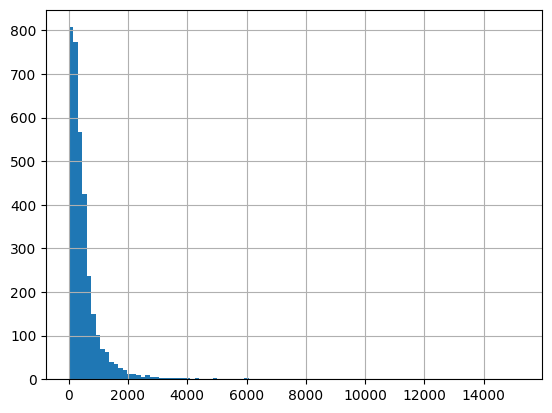

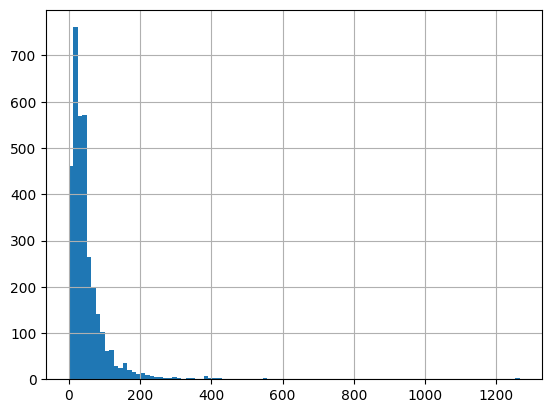

In [838]:
# how many selftext were truncated
df_sub_temp = df_sub.copy()
print('over 514 char', df_sub_temp.loc[df_sub_temp['length'] > 514].shape)
print('all', df_sub_temp.shape)
df_sub_temp['length'].hist(bins=100)
plt.show()

# cleaned text length
df_sub_temp['clean_text_len'] = df_sub_temp['clean_text'].apply(len)
df_sub_temp['clean_text_len'].hist(bins=100)
plt.show()


#### DF REDDIT COMMENTS -- load

In [38]:
data_path_comm = "stonkgo_reddit-data-bitcoin_filtered_data_comments_comments_2023-06-30_to_2023-12-31.parquet"

df_comm_raw = pd.read_parquet(data_path_comm)
#print(df_sub_raw.dtypes)

print(df_comm_raw.columns)

df_comm_raw.head(2)


Index(['link_id', 'controversiality', 'score', 'body', 'gilded', 'name',
       'archived', 'parent_id', 'id', 'author', 'subreddit_id', 'retrieved_on',
       'created_utc', 'collapsed', 'permalink', 'no_follow', 'send_replies',
       'gildings', 'locked', 'all_awardings', 'total_awards_received',
       'treatment_tags', 'author_flair_richtext', 'author_fullname', 'ups',
       'downs', 'created', 'awarders', 'author_created_utc',
       'author_flair_text', 'author_flair_css_class', 'distinguished'],
      dtype='object')


,link_id,controversiality,score,body,gilded,name,archived,parent_id,id,author,...,author_flair_richtext,author_fullname,ups,downs,created,awarders,author_created_utc,author_flair_text,author_flair_css_class,distinguished
13751851,t3_14mkdqh,0,5,State retirement fund and BTC. If I had more m...,0,t1_jq2c9m4,False,t3_14mkdqh,jq2c9m4,NoShip7475,...,[],t2_etpwak36,5,0,1688083217,[],nan,,None,None
13751852,t3_14mdie8,0,1,Absolutely 0 into alt coins(shitcoins). Depend...,0,t1_jq2cb3t,False,t3_14mdie8,jq2cb3t,lastusernsme,...,[],t2_54w176qt,1,0,1688083235,[],nan,None,None,None


In [39]:

def enhance_reddit_comments(df):
    """
    link_id: submission_id
    """
    
    # rename common fields

    df.rename(columns={
        'body': 'selftext',
        'link_id' : 'id_sub_t', 'parent_id': 'id_comm_parent', 'id': 'id_comm', 'name': 'id_comm_t'
    }, inplace=True)

    # drop nas
    df.dropna(subset=["selftext"], inplace=True)
    df.selftext = df.selftext.astype("string")

    # add selftext truncated to 514 characters
    df['selftext_trunc514'] = df['selftext'].apply(lambda x: x[:514])

    # calc original length of text
    df['length'] = df['selftext'].apply(len)
    df['length_trunc514'] = df['selftext_trunc514'].apply(len)

    # convert created_utx in unix to datetime
    #df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
    # rename as 'timestamp'
    #df.rename(columns={'created_utc': 'timestamp'}, inplace=True)
    # retrieved on
    df['retrieved_on'] = pd.to_datetime(df['retrieved_on'], unit='s')
    # convert to EST, adjusting for daylight savings 
    #df['created_utc'] = df['created_utc'] - pd.Timedelta(hours=5) - pd.Timedelta(hours=1)

    # convert from object to float
    df['total_awards_received'] = df['total_awards_received'].fillna(0).astype(float)
    df['ups'] = df['ups'].astype(float)
    df['downs'] = df['downs'].astype(float)
    df['controversiality'] = df['controversiality'].astype(float)
    df['score'] = df['score'].astype(float)

    # drop columns 
    #df.drop(columns = ['link_id', 'created', 'name'], inplace = True)
    df.drop(columns=['downs', 'created'], inplace=True) # downs is always 0
    #
    #df['all_awardings'] = df['all_awardings'].fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

# trim
df_comm = enhance_reddit_comments(df_comm_raw.copy())

# format fields into different data types
# score must be integer
#df_sub['score'] = df_sub['score'].fillna(0).astype(int)
#df_sub = df_sub.loc[df_sub['score'] > 1].reset_index(drop = True).copy()

print('df_comm shape:', df_comm.shape)

#df_comm.sort_values(['score'], ascending = [False])

#df_comm.iloc[10000:10001].T




/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/1872813013.py:29: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['retrieved_on'] = pd.to_datetime(df['retrieved_on'], unit='s')


df_comm shape: (452275, 33)


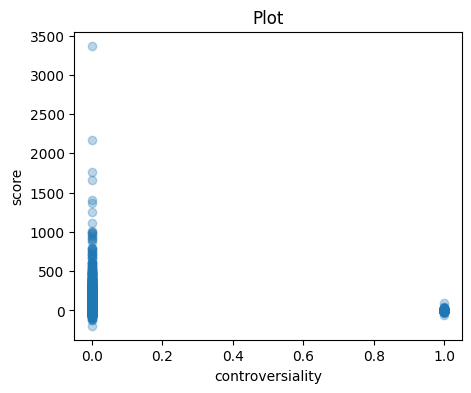

In [40]:
# plot df_reddit columns in scatter
df_plot_comm = df_comm.copy()
plt.figure(figsize=(5, 4))
x_axis_field = 'controversiality'
y_axis_field = 'score'
plt.scatter(((df_plot_comm[x_axis_field])), ((df_plot_comm[y_axis_field])), alpha=0.3)
plt.xlabel(x_axis_field)
plt.ylabel(y_axis_field)
plt.title('Plot')

plt.show()


In [41]:
#df_comm.loc[df_comm.id_submission == 't3_14r7c43'][['id_submission', 'score','selftext', 'id_comment_t', 'id_parent', 'id_comment', 'created_utc', 'retrieved_on']].sort_values('created_utc', ascending = True)

temp_list = df_comm.loc[df_comm.controversiality > 0].sort_values(['score', 'created_utc'], ascending = [False, False]).id_sub_t.unique()#.to_csv('temp.csv')
temp_list

array(['t3_180do84', 't3_18cu4f5', 't3_18kt484', ..., 't3_17xlmoq',
       't3_18jnkho', 't3_17nfnj5'], dtype=object)

In [42]:
df_comm.loc[df_comm.id_sub_t == 't3_18a5g8y'][['selftext','controversiality', 'score', 'ups', 'total_awards_received']].sort_values(['controversiality'], ascending = False)

,selftext,controversiality,score,ups,total_awards_received
355026,"Good, now pls drop to 10k again so I can afford.",1.0,3.0,3.0,0.0
355641,This is a major criticism of bitcoin being tie...,1.0,3.0,3.0,0.0
355280,Most people setting up sell walls at a particu...,1.0,1.0,1.0,0.0
355857,1 BTC = 1 BTC or Freedom = Freedom,1.0,-1.0,-1.0,0.0
355050,More likely than 100k,1.0,1.0,1.0,0.0
...,...,...,...,...,...
355318,Yeah kinda weird whenever I see that but I thi...,0.0,5.0,5.0,0.0
355312,We had 14k in 2019.,0.0,2.0,2.0,0.0
355311,because altcoins are shit coins,0.0,11.0,11.0,0.0
355305,Onward to 59k and beyond!,0.0,1.0,1.0,0.0


#### Sentiment Scores, individual
Two models

In [43]:
## CHOSE MODEL --> get results

""" 
"""
#TWITTER POS/NEG/NEUTRAL
model_twit_string = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model_twit = AutoModelForSequenceClassification.from_pretrained(model_twit_string)
tokenizer_twit = AutoTokenizer.from_pretrained(model_twit_string)
labels = ['negative', 'neutral', 'positive']

# call this for df_temp.selftext_trunc514
def get_sentiment_score(tweet):
    encoded_input = tokenizer_twit(tweet, return_tensors='pt')
    output = model_twit(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    score_dict = {}
    for i, score in enumerate(scores):
        label = labels[i]
        score_dict[label] = score
    return score_dict

classification_twit = df_sub['selftext_trunc514'].apply(get_sentiment_score)


##########################


#EMOTIONS
classifier_emotions = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
#sentences = ["I am not having a great day"]
#classifier_emotions(sentences)
#print(model_emotions_outputs[0])
classification_results = classifier_emotions(df_sub.selftext_trunc514.to_list())

#classification_results


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
## MASSAGE RESULTS. ADD TO DATA.

## TWITTER MODEL
senti_twit_prefix = 'senti_twit_'

df_senti_twit = pd.DataFrame()

# Iterate over the classification results
for result in classification_twit:
    df_senti_twit = pd.concat([df_senti_twit, pd.DataFrame(result, index=[0])], ignore_index=True)
df_senti_twit.columns = [senti_twit_prefix + x for x in df_senti_twit.columns]

df_senti_twit

###################################

# EMOTIONS MODEL

df_result_emotions_temp = pd.DataFrame(
    [{'classification_result': result} for result in classification_results]
)
# create empty dataframe with column names of each emotion
senti_prefix = 'senti_emotions_'
df_senti_emotions = pd.DataFrame(columns=[senti_prefix + x['label'] for x in classification_results[0]])
# Iterate over the classification results
for result in classification_results:
    # Extract the scores for each emotion label
    scores = [x['score'] for x in result]
    
    # Create a dictionary with emotion labels as keys and scores as values
    #emotion_scores = {x['label']: x['score'] for x in result} # without prefix
    emotion_scores = {senti_prefix + x['label']: x['score'] for x in result}

    # Concatenate the emotion scores to the dataframe
    df_senti_emotions = pd.concat([df_senti_emotions, pd.DataFrame(emotion_scores, index=[0])], ignore_index=True)
df_senti_emotions

# access the classification result in order of the listed emotions
#print(df_result_emotions['classification_result'][0][0]['label'])
#print(df_result_emotions['classification_result'][0][0]['score'])

# access entire dictionary of classification results
#df_result_emotions['classification_result'][0]
# get first three elements of the classification result
#df_result_emotions['classification_result'][0][:3]

# get maximum score and corresponding label
#max_score = max([x['score'] for x in df_result_emotions['classification_result'][0]])
#max_label = [x['label'] for x in df_result_emotions['classification_result'][0] if x['score'] == max_score]
#print(max_score)
#print(max_label)

# split each emotion and emotion score into separate columns
#df = pd.DataFrame([{emotion: score for emotion, score in result['scores'].items()} for result in classification_results])

/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/490530515.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_senti_emotions = pd.concat([df_senti_emotions, pd.DataFrame(emotion_scores, index=[0])], ignore_index=True)


,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id_sub,is_crosspostable,is_self,...,senti_emotions_disgust,senti_emotions_gratitude,senti_emotions_embarrassment,senti_emotions_remorse,senti_emotions_relief,senti_emotions_grief,senti_emotions_pride,senti_twit_negative,senti_twit_neutral,senti_twit_positive
0,False,bigoldbert23,True,False,2023-06-30 07:40:46,0,False,14mtr55,True,True,...,0.001293,0.001263,0.001135,0.001032,0.000654,0.000491,0.000228,0.072050,0.829108,0.098842
1,False,BitDeRobbers,True,False,2023-06-30 08:05:33,0,False,14mu6tc,True,True,...,0.001223,0.003500,0.001146,0.001589,0.000875,0.000379,0.000394,0.004808,0.862190,0.133003
2,False,Rajang7,True,False,2023-06-30 08:31:59,0,False,14mumyp,True,False,...,0.002216,0.000666,0.000645,0.000308,0.000254,0.000308,0.000246,0.058143,0.890914,0.050943
3,False,Salty_Dragonfruit336,True,False,2023-06-30 08:36:23,0,False,14mupjc,True,True,...,0.000829,0.000666,0.000368,0.000622,0.000343,0.000318,0.000133,0.023948,0.700258,0.275794
4,False,Scroberts96,True,False,2023-06-30 08:53:03,0,False,14muzrh,True,True,...,0.001408,0.008741,0.001120,0.000775,0.009502,0.000836,0.004367,0.005524,0.036058,0.958418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,False,Possible-Magazine23,False,False,2023-12-31 04:05:51,0,False,18uyvql,True,True,...,0.001389,0.000902,0.001730,0.000590,0.000493,0.000521,0.000218,0.287607,0.685726,0.026666
3416,False,inchaneZ,False,False,2023-12-31 05:06:03,0,False,18v000o,True,True,...,0.000929,0.000978,0.000587,0.000676,0.000201,0.000282,0.000069,0.030707,0.913519,0.055774
3417,False,rBitcoinMod,False,False,2023-12-31 06:06:54,0,False,18v13mx,True,True,...,0.000621,0.879730,0.000492,0.001524,0.001866,0.000332,0.000386,0.028558,0.565048,0.406394
3418,False,Bitbuyer313,False,False,2023-12-31 06:29:19,0,False,18v1hd6,True,True,...,0.000781,0.000529,0.000234,0.000163,0.000943,0.000154,0.000631,0.371952,0.577079,0.050969


In [122]:

#####################################
## MERGE SENTI RESULTS WITH ORIGINAL DATA
df_sub_senti = pd.concat([df_sub, df_senti_emotions, df_senti_twit], axis=1)
df_sub_senti


,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id_sub,is_crosspostable,is_self,...,senti_emotions_disgust,senti_emotions_gratitude,senti_emotions_embarrassment,senti_emotions_remorse,senti_emotions_relief,senti_emotions_grief,senti_emotions_pride,senti_twit_negative,senti_twit_neutral,senti_twit_positive
0,False,bigoldbert23,True,False,2023-06-30 07:40:46,0,False,14mtr55,True,True,...,0.001293,0.001263,0.001135,0.001032,0.000654,0.000491,0.000228,0.072050,0.829108,0.098842
1,False,BitDeRobbers,True,False,2023-06-30 08:05:33,0,False,14mu6tc,True,True,...,0.001223,0.003500,0.001146,0.001589,0.000875,0.000379,0.000394,0.004808,0.862190,0.133003
2,False,Rajang7,True,False,2023-06-30 08:31:59,0,False,14mumyp,True,False,...,0.002216,0.000666,0.000645,0.000308,0.000254,0.000308,0.000246,0.058143,0.890914,0.050943
3,False,Salty_Dragonfruit336,True,False,2023-06-30 08:36:23,0,False,14mupjc,True,True,...,0.000829,0.000666,0.000368,0.000622,0.000343,0.000318,0.000133,0.023948,0.700258,0.275794
4,False,Scroberts96,True,False,2023-06-30 08:53:03,0,False,14muzrh,True,True,...,0.001408,0.008741,0.001120,0.000775,0.009502,0.000836,0.004367,0.005524,0.036058,0.958418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,False,Possible-Magazine23,False,False,2023-12-31 04:05:51,0,False,18uyvql,True,True,...,0.001389,0.000902,0.001730,0.000590,0.000493,0.000521,0.000218,0.287607,0.685726,0.026666
3416,False,inchaneZ,False,False,2023-12-31 05:06:03,0,False,18v000o,True,True,...,0.000929,0.000978,0.000587,0.000676,0.000201,0.000282,0.000069,0.030707,0.913519,0.055774
3417,False,rBitcoinMod,False,False,2023-12-31 06:06:54,0,False,18v13mx,True,True,...,0.000621,0.879730,0.000492,0.001524,0.001866,0.000332,0.000386,0.028558,0.565048,0.406394
3418,False,Bitbuyer313,False,False,2023-12-31 06:29:19,0,False,18v1hd6,True,True,...,0.000781,0.000529,0.000234,0.000163,0.000943,0.000154,0.000631,0.371952,0.577079,0.050969


## DF_REDDIT

Enhance Reddit data. Filter again. 

In [123]:
df_reddit = df_sub_senti.copy()

#df_reddit.columns

Index(['archived', 'author', 'can_gild', 'contest_mode', 'timestamp', 'gilded',
       'hidden', 'id_sub', 'is_crosspostable', 'is_self', 'is_video',
       'link_flair_richtext', 'locked', 'no_follow', 'num_comments',
       'num_crossposts', 'permalink', 'retrieved_on', 'score',
       'secure_media_embed', 'selftext', 'send_replies', 'stickied', 'title',
       'is_original_content', 'id_sub_t', 'quarantine', 'pinned', 'media_only',
       'subreddit_subscribers', 'gildings', 'all_awardings',
       'total_awards_received', 'awarders', 'treatment_tags', 'upvote_ratio',
       'is_created_from_ads_ui', 'author_flair_type', 'author_fullname',
       'author_flair_richtext', 'removed_by_category', 'post_hint',
       'link_flair_text', 'author_created_utc', 'author_flair_css_class',
       'secure_media', 'link_flair_css_class', 'text', 'created_date',
       'clean_text', 'row_number', 'sentiment_analysis', 'selftext_trunc514',
       'length', 'length_trunc514', 'relevancy_score',
  

array(['None', 'repetitive', 'bitcoinmarkets', 'non-english',
       'financial advice', 'duplicate', 'low quality', 'bad link', 'meta',
       'scam', 'off topic', 'price', 'misleading', 'no context',
       'altcoin', 'customer support', 'spam', 'mining', 'see sticky',
       'meme', 'comment as submission', 'do not encourage brigading',
       'referral', 'begging', 'trading',
       "there's already a thread & this has nothing to do with Bitcoin",
       'not yet'], dtype=object)

### Enhance -- add fields, metrics

add metrics

In [129]:
def redditEnhance(df):
    # timestamp bucket (nearest hour)
    df['timeBucket'] = df['timestamp'].dt.round('h')

    # add ret_fwd column using dict
    return_field = 'ret_fwd_120_h'
    df['ret_fwd_target'] = df['timeBucket'].map(ret_fwd_120_dict)

    # create score quantiles
    df['score_quantile'] = (pd.qcut(df['score'], q=5, labels=False) + 1)

    # select weighting metric
    #df['weight'] = (df['score_quantile']**2).copy()
    df['weight'] = (df['score_quantile']**2) * \
                                df['relevancy_score'] * \
                                np.log(df['num_comments']+1)

    # fwd return with direction
    df['senti_twit_dir'] = np.where((df['senti_twit_positive'] > df['senti_twit_negative']) & (df['senti_twit_positive'] > df['senti_twit_neutral']), 
                                    1, 
                                    np.where((df['senti_twit_negative'] > df['senti_twit_positive']) & (df['senti_twit_negative'] > df['senti_twit_neutral']), 
                                             -1, 0))

    df['ret_fwd_target_adj'] = df['ret_fwd_target'] * df['senti_twit_dir']

    return df

# Usage example:
df_reddit = redditEnhance(df_reddit)
df_reddit.head(5)
df_reddit.columns


,archived,author,can_gild,contest_mode,timestamp,gilded,hidden,id_sub,is_crosspostable,is_self,...,senti_emotions_pride,senti_twit_negative,senti_twit_neutral,senti_twit_positive,timeBucket,ret_fwd_target,score_quantile,weight,senti_twit_dir,ret_fwd_target_adj
0,False,bigoldbert23,True,False,2023-06-30 07:40:46,0,False,14mtr55,True,True,...,0.000228,0.072050,0.829108,0.098842,2023-06-30 08:00:00,0.000298,3,242.0,0,0.000000
1,False,BitDeRobbers,True,False,2023-06-30 08:05:33,0,False,14mu6tc,True,True,...,0.000394,0.004808,0.862190,0.133003,2023-06-30 08:00:00,0.000298,4,81.0,0,0.000000
2,False,Rajang7,True,False,2023-06-30 08:31:59,0,False,14mumyp,True,False,...,0.000246,0.058143,0.890914,0.050943,2023-06-30 09:00:00,-0.002908,5,32042.0,0,-0.000000
3,False,Salty_Dragonfruit336,True,False,2023-06-30 08:36:23,0,False,14mupjc,True,True,...,0.000133,0.023948,0.700258,0.275794,2023-06-30 09:00:00,-0.002908,4,800.0,0,-0.000000
4,False,Scroberts96,True,False,2023-06-30 08:53:03,0,False,14muzrh,True,True,...,0.004367,0.005524,0.036058,0.958418,2023-06-30 09:00:00,-0.002908,5,732.0,1,-0.002908


### REDDIT EDA

#### Check distributions of each reddit variable for ideas on how to weight. 

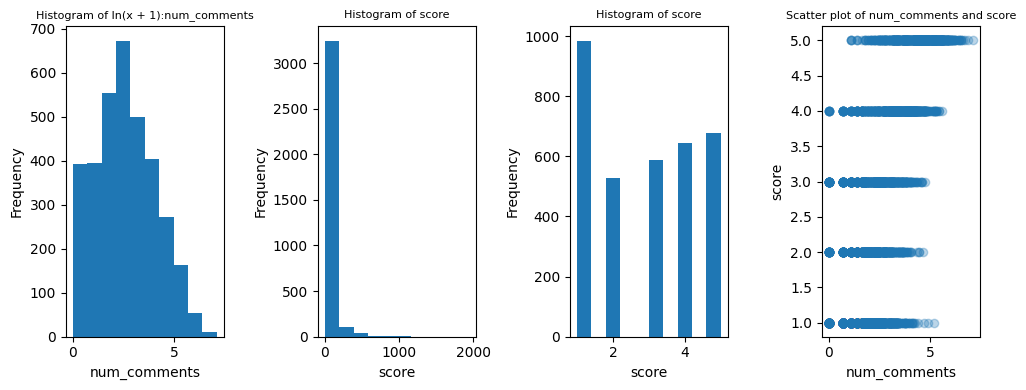

In [916]:
# plot df_reddit columns in scatter
var_a = 'num_comments'
var_b = 'score'
var_c = 'score_quantile'


fig, axs = plt.subplots(1, 4, figsize=(10, 4))  # Create a figure with two subplots

# var_a
axs[0].hist(np.log(df_reddit[var_a]+1))
axs[0].set_xlabel(var_a)
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of ln(x + 1):' + var_a, fontsize=8)

# var_b
axs[1].hist(df_reddit[var_b])
axs[1].set_xlabel(var_b)
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of ' + var_b, fontsize=8)

# var_b
axs[2].hist(df_reddit[var_c])
axs[2].set_xlabel(var_b)
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of ' + var_b, fontsize=8)

# var_c
axs[3].scatter(np.log(df_reddit[var_a]+1), df_reddit[var_c], alpha=0.3)
axs[3].set_xlabel(var_a)
axs[3].set_ylabel(var_b)
axs[3].set_title('Scatter plot of ' + var_a + ' and ' + var_b, fontsize=8)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


#### Correlation

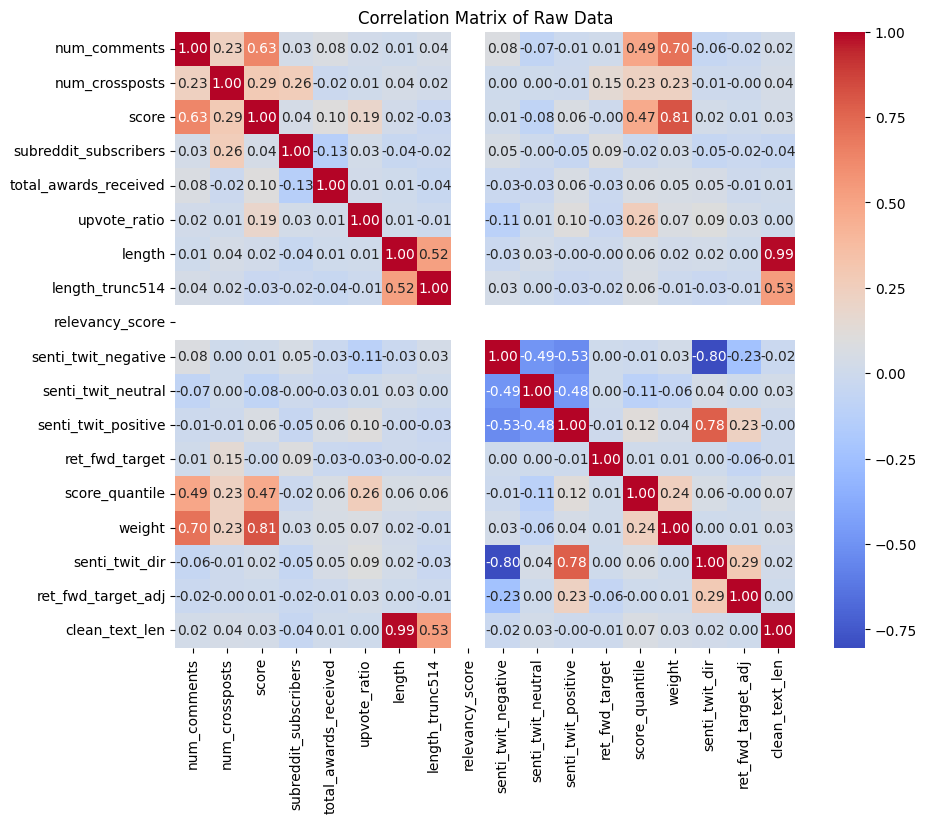

In [918]:
# correlation matrix of data_raw
df_reddit_floats = df_reddit.select_dtypes(include=['float32','float64', 'int64']).copy()

# drop senti_ columns
df_reddit_floats_xEmotions = df_reddit_floats.loc[:, ~df_reddit_floats.columns.str.startswith('senti_emotions_')]

plt.figure(figsize=(10, 8))
sns.heatmap(df_reddit_floats_xEmotions.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Raw Data')
plt.show()


#### Author - do they have alpha?

In [852]:
df_author = df_reddit.copy()

df_author.head(2)

df_author_grouped = df_author.groupby(['author']).agg({
    'id_sub': [('count', 'count')], # number of submissions
    'score': [('score_avg', 'mean')],
    'num_comments': [('num_comments_avg', 'mean')],
    'ret_fwd_target_adj': [('ret_fwd_target_adj_avg', 'mean'), ('ret_fwd_target_adj_std', lambda x: np.nanstd(x, ddof=1))],
})
df_author_grouped.columns = df_author_grouped.columns.droplevel(0)
df_author_grouped.reset_index(drop=False, inplace = True)
#df_author_grouped.sort_values(by='score_avg', ascending=False)
#df_author_grouped.sort_values(by='count', ascending=False)
df_author_grouped.sort_values(by='ret_fwd_target_adj_avg', ascending=False)

df_author_grouped.describe()


/Users/annahan/opt/anaconda3/envs/env2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,count,score_avg,num_comments_avg,ret_fwd_target_adj_avg,ret_fwd_target_adj_std
count,2402.000000,2402.000000,2402.000000,2266.000000,407.000000
mean,1.423813,38.924334,36.631159,-0.000990,0.015740
std,2.401631,105.739052,74.475047,0.023854,0.021295
min,1.000000,2.000000,0.000000,-0.149647,0.000000
25%,1.000000,3.000000,4.500000,0.000000,0.000000
50%,1.000000,8.000000,12.000000,0.000000,0.008222
75%,1.000000,29.000000,35.000000,0.000000,0.024009
max,98.000000,1942.000000,1200.000000,0.147115,0.121158


#### Other Fields

In [857]:
df_reddit.columns

Index(['archived', 'author', 'can_gild', 'contest_mode', 'timestamp', 'gilded',
       'hidden', 'id_sub', 'is_crosspostable', 'is_self', 'is_video',
       'link_flair_richtext', 'locked', 'no_follow', 'num_comments',
       'num_crossposts', 'permalink', 'retrieved_on', 'score',
       'secure_media_embed', 'selftext', 'send_replies', 'stickied', 'title',
       'is_original_content', 'id_sub_t', 'quarantine', 'pinned', 'media_only',
       'subreddit_subscribers', 'gildings', 'all_awardings',
       'total_awards_received', 'awarders', 'treatment_tags', 'upvote_ratio',
       'is_created_from_ads_ui', 'author_flair_type', 'author_fullname',
       'author_flair_richtext', 'removed_by_category', 'post_hint',
       'link_flair_text', 'author_created_utc', 'author_flair_css_class',
       'secure_media', 'link_flair_css_class', 'text', 'created_date',
       'clean_text', 'row_number', 'sentiment_analysis', 'selftext_trunc514',
       'length', 'length_trunc514', 'relevancy_score',
  

In [882]:
df_reddit.is_original_content.value_counts(normalize = True) # T/F. mostly False. 
df_reddit.media_only.value_counts(normalize = True) # T/F
df_reddit.all_awardings.value_counts(normalize = True) 
df_reddit.total_awards_received.value_counts(normalize = True)
df_reddit.awarders.value_counts(normalize = True)
df_reddit.treatment_tags.value_counts(normalize = True)
df_reddit.is_created_from_ads_ui.value_counts(normalize = True)
df_reddit.author_flair_type.value_counts(normalize = True) # text vs richtext
df_reddit.post_hint.value_counts(normalize = True) # nan, image, self, link, hosted:video, rich;video
df_reddit.link_flair_text.value_counts(normalize = True) # -- USEFUL -- ex. 'off topic', 'scam', 'misleading' ################
df_reddit.link_flair_css_class.value_counts(normalize = True) #
df_reddit.author_flair_css_class.value_counts(normalize = True) # none, noob
df_reddit.author_flair_richtext.value_counts(normalize = True) # mostly [], some are redditor for xx months/weeks/days
df_reddit.secure_media.value_counts(normalize = True) # if link to external is included

0       Multiple hardware wallets? Do you use a single...
1       Bitcoin Standard is on sale for £2.99 today fo...
2       Bitcoin only accomodations site, AirBTC, is li...
3       Will there something called a bitcoinnaire? He...
4       Back In The Game Finally back in the game afte...
                              ...                        
3415    Sent thru Lightning without specific invoice a...
3416    Hyperbitcoinization When do you think it will ...
3417    Daily Discussion, December 31, 2023 Please uti...
3418    Bitcoin is the path of least resistance, gover...
3419    Passphrases will save you or kill your savings...
Name: text, Length: 3420, dtype: object

#### Useful to Find Bots, Moderators, Spam - link_flair_text

link_flair_text: array(['None', 'repetitive', 'bitcoinmarkets', 'non-english',
       'financial advice', 'duplicate', 'low quality', 'bad link', 'meta',
       'scam', 'off topic', 'price', 'misleading', 'no context',
       'altcoin', 'customer support', 'spam', 'mining', 'see sticky',
       'meme', 'comment as submission', 'do not encourage brigading',
       'referral', 'begging', 'trading',
       "there's already a thread & this has nothing to do with Bitcoin",
       'not yet'], dtype=object)

In [932]:
df_reddit.link_flair_text.value_counts()

# display as percentage of total
df_reddit.link_flair_text.value_counts(normalize=True)

link_flair_text
None                                                              0.890351
bitcoinmarkets                                                    0.023977
repetitive                                                        0.021637
price                                                             0.010526
off topic                                                         0.008480
financial advice                                                  0.008187
low quality                                                       0.008187
altcoin                                                           0.003801
scam                                                              0.003509
duplicate                                                         0.002924
no context                                                        0.002632
non-english                                                       0.002632
misleading                                                        0.002047
see stick

In [936]:
# Set display option to show entire string
pd.set_option('display.max_colwidth', None)

df_reddit.link_flair_text.value_counts()

df_reddit.loc[
    df_reddit.link_flair_text.isin(['off topic']) #'scam', 'misleading'
    ][[
        'selftext', 'score', 'num_comments', 'author'
        ]].head(10)


,selftext,score,num_comments,author
228,"As professionals, we often find ourselves juggling countless tasks, chasing deadlines, and striving for success. Amidst this whirlwind, it's crucial to recognize that time is our most valuable asset. ⏱️💎 ""Time is the only capital that any human being has, and it is the only thing they can't afford to lose."" ⚡️ ⭐️ So, how can we make the most of this precious resource? Here are a few tips to optimize your time management skills and boost productivity: ⭐️ 1️⃣ Prioritize ruthlessly: Identify your most important tasks and focus on completing them first. Don't get caught up in trivial matters that steal your time. 2️⃣ Set realistic goals: Break down big projects into smaller, manageable tasks. Set specific, achievable goals for each day and track your progress. 📈 3️⃣ Eliminate distractions: Create a conducive work environment by minimizing interruptions. Silence notifications, find a quiet space, and dedicate uninterrupted blocks of time for deep work. 🚫📱 4️⃣ Delegate and collaborate: Don't hesitate to delegate tasks that can be handled by others. Effective collaboration can save time and enhance outcomes. 🤝💼 5️⃣ Take strategic breaks: Avoid burnout by scheduling regular breaks. Stepping away from work can help refresh your mind, increase focus, and maintain overall productivity. ☕🧘‍♂️ Remember, time is a limited resource, but by managing it wisely, we can achieve remarkable things! ⏰🌟 Let's embrace the power of effective time management and unlock our full potential. Share your favorite time management tips in the comments below! ⏱️💪✨",2,2.0,Sheikh_Hashir_F
320,https://youtu.be/Pk5Nz9jp13Y,3,1.0,Only_Dog_3234
326,This app ain’t twitter for real,2,3.0,Dreuzx
724,The Argentina situation is dire. Net Treasury - Negative $50 Bil - GDP $500 Bil (10% of GDP as NET debt). Gold $4 Bil. Gold is likely locked (can’t be converted or withdrawn). Tax collections $80 Bil. Nat Debt $400 Bil - Interest payments on debt near $25 Bil / yr. Gov budget $190 Bil. lol Basically Gov Budget needs 80% slash - to $40 Bil + Interest to come out even. https://www.imf.org/-/media/Files/Publications/CR/2023/English/1ARGEA2023002.ashx,3,1.0,Bitcoin1776
928,A Follow Will Be Appriciated https://www.instagram.com/reel/CzdBHYnPRRX/?igshid=MWt0OXIzZmtlZGp6aw==,2,1.0,luser9906
1026,"Michael Saylor is talking here at the ""Australian Crypto Convention"" about the difference between Bitcoin Spot ETFs and MicroStrategy stock as a leveraged bet on Bitcoin: https://youtu.be/H7JvWJIvwd0?si=i3VLjzfVCsppmvGj&t=1213 I'm trying to summarize/understand as concisely as possibly *why* MSTR can be considered a ""leveraged bet on Bitcoin"" and *how* does the strategy behind this work. Quote: >A Levered Bet >So why aren’t investors just buying Bitcoin, or GBTC, or BITO? >One reason is the disadvantages above. But another key reason is precisely the debt on MicroStrategy’s balance sheet. MSTR is a leveraged bet on Bitcoin. >That leverage has inherent value. It’s part of why MSTR, despite paying $30,000 for Bitcoin now worth $20,000 now, has kept up with the underlying cryptocurrency over the past 23 months. >Put another way, what MSTR represents is an in-the-money call option on Bitcoin prices. If Bitcoin soars, the stock should outperform. >The catch, however, is that the outperformance has to be significant. Imagine, for instance, that Bitcoin rebounds to $40,000. MicroStrategy’s holdings now are worth $5.2 billion. The operating business still is worth $1 billion; debt of cash stays the same at about $2.3 billion. >In theory, MicroStrategy now should have a market cap of $3.9 billion. The catch is that in this scenario, BTC/USD has more than doubled; fundamentally speaking, MSTR should not. >Perhaps there’s more optionality value from that point that makes up the difference, but the broad point holds. There is some logic as to why MSTR should trade at a premium to the value of its assets, but there’s a real question as to whether the prem

In [935]:
# Set display option to show entire string
pd.set_option('display.max_colwidth', None)

df_reddit.link_flair_text.value_counts()

df_reddit.loc[
    df_reddit.link_flair_text.isin(['scam'])
    ][[
        'selftext', 'score', 'num_comments', 'author'
        ]].head(10)

# get list of authors who have posted 'scam' posts
list_author_scam = df_reddit.loc[
    df_reddit.link_flair_text.isin(['scam'])
    ]['author'].unique()

list_author_scam

# get all posts by authors who have posted 'scam' posts
df_reddit.loc[
    df_reddit.author.isin(list_author_scam)
    ][[
        'selftext', 'score', 'num_comments', 'author'
        ]]

,selftext,score,num_comments,author
226,"I have received several spam emails containing the same Bitcoin address (1DkKm1sWz6yEHiqjEusuA23BKqk4gDTVbK), which are sextortion - drive by exploit claim (https://geeksadvice.com/remove-drive-by-exploit-email/). I don’t have a webcam, the emailer threatens to expose me nude etc etc and lists a phone number claiming to be mine. It’s kind of funny how they copy the script and attempt to be pleasant. I thought maybe some crypto sleuths would like to have a little fun and investigate some of the prior 25 transactions this account has performed, received 0.36970144btc. The senders emails are listed as: JohnBlue@9724.com JohnBlue@0358.com JohnBlue@1395.com JohnBlue@8796.com Here is the email: Hi, today there are sadly some bad news for you. Your device was infected with my private malware, your browser wasn't updated / patched, in such case it's enough to just visit some website where my iframe is placed to get automatically infected, if you want to find out more, Google: Drive-by exploit. My malware gave me full access to all your accounts, full control over your device and it also was possible to spy on you over your cam. If you think this is some bad joke, no, for example I know your phone number: ………… I collected all your private data and I RECORDED YOU (through your cam) SATISFYING YOURSELF! After that I removed my malware to not leave any traces and this email was sent from some hacked server. I can publish the video of you and all your private data on the whole web, social networks, over email and send everything to all your contacts. But you can stop me and only I can help you out in this situation. The only way to stop me, is to pay exactly 750$ in Bitcoin (BTC). It's a very good offer, compared to all that horrible shit that will happen if I publish everything. You can easily buy Bitcoin (BTC) here: www(dot)paxful(dot)com , www(dot)coingate. (Dot)com , www(dot)coinbase(dot)com , or check for Bitcoin (BTC) ATM near you, or Google for other exchanger. You can send the Bitcoin (BTC) directly to my wallet, or install the free software: Atomicwallet, or: Exodus wallet, then receive and send to mine. My Bitcoin (BTC) wallet is: 1DkKm1sWz6yEHiqjEusuA23BKqk4gDTVbK Yes, that's how the wallet / address looks like, copy and paste it, it's (cAsE-sEnSEtiVE). I give you 3 days time to pay. After receiving the payment, I will remove everything and you can life your live in peace like before, don't worry, I keep my promise. Next time make sure that your device got the newsest security updates.",2,2.0,Man_clash
807,"To keep it short and not attract the hord, what is this and how do i access it? Its hidden and i cant transfer it swap it in any way. https://preview.redd.it/t2ovk6etsvyb1.png?width=384&format=png&auto=webp&s=2e98b325c228b8798e233e1a864a693f11f28262",3,7.0,distraxxx
1204,"hey so I need some advice/help how does one go about selling a huge amount of BTC like 200k BTC, should I contact private firms or private brokers , if you've sold or have first hand experience with a lot of bitcoin being sold , i need some advice on how to go about this. Any advice will really help me out",3,10.0,Anxious_Tune3148
1469,"Seeing some physical bitcoin cold storage wallets printed on paper, evidently made in germany being sold on ebay. Anyone here have experience with these, and/or have information on the issuer, security issues/breaches, etc. tia",2,4.0,eebnamtna
1543,If it is? What do I do with it?,3,2.0,unpackyourmind
1567,"&#x200B; [So, i want to withdrawal the bitcoins i mined, but first i need to deposit, anyone can help me with this?](https://preview.redd.it/88q4anv2vi2c1.png?width=1190&format=png&auto=webp&s=4b9f2a036a630d8858806587f4ea89bae2c42ea1)",2,3.0,Operation20
1651,"How do I cash them out without deposit? If someone could help me, I can also send part of the money that I will receive.",2,4.0,meydolla
1778,"A spam email received from ""Mozilla Addons"" and screenshot of [mozilla.org](https:

## JOIN: BTC and SUBMISSIONS SENTIMENT

### Rolling Lookback Window

In [995]:
#df_sub_senti
#df_btc_signal
#df_merged = df_btc_signal.copy()
df_merged = df_btc.copy()

# trim to where we have data for df_sub_senti
df_merged = df_merged.loc[df_merged.timestamp >= df_sub_senti.timestamp.min()].reset_index(drop = True).copy()



list_lookback_window = [120, 7*24, 240, 15*24]
#list_lookback_window = [x*3 for x in list_lookback_window]

df_senti_rolling = pd.DataFrame()
df_senti_rolling_wgt = pd.DataFrame()
df_senti_rolling_timeDecay = pd.DataFrame()
df_senti_rolling_wgt_timeDecay = pd.DataFrame()

dict_df_window_wgt = {}
# create nested dictionary

for window in list_lookback_window:
    df_senti_rolling_temp = pd.DataFrame()
    df_senti_rolling_wgt_temp = pd.DataFrame()
    df_senti_rolling_timeDecay_temp = pd.DataFrame()
    df_senti_rolling_wgt_timeDecay_temp = pd.DataFrame()

    dict_df_window_wgt[window] = {}  # Create an empty inner dictionary for each window value
    for i in range(len(df_merged)):
        # get the start and end timestamp of the time window
        #start = df_merged.loc[i, 'timestamp_lookback']
        end = df_merged.loc[i, 'timestamp']
        start = end - pd.Timedelta(hours=window)
    
        # subset df_reddit to only include rows that fall within the time window, and
        df_window = df_reddit.loc[(df_reddit['timestamp'] >= start) & (df_reddit['timestamp'] < end)].copy()
        
        # add column for nearest timestamp rounded to hour
        df_window['timestamp_hour'] = df_window['timestamp'].dt.round('h')
        df_window['time_diff_hours'] = (end - df_window['timestamp']).dt.total_seconds() / 3600
        
        # create a time decay weight, that has half life of 120 hours
        df_window['timeDecay'] = 0.5**(df_window['time_diff_hours'] / 24)
    
        # define weighting scheme
        df_window['weight'] = (df_window['score_quantile']**2) * \
                                df_window['relevancy_score'] * \
                                np.log(df_window['num_comments']+1)
        df_window['weight_timeDecay'] = (df_window['score_quantile']**2) * \
                                        df_window['relevancy_score'] * \
                                        np.log(df_window['num_comments']+1) * \
                                            df_window['timeDecay']

        # add new features
        df_window['senti_sub_freq'] = df_window.shape[0]/window

        # add df_window to dict_df_window_wgt
        dict_df_window_wgt[window][end] = df_window.copy()
        #print(end)

        #print(dict_df_window_wgt)
        
        # subset of df_window with column names that contain 'senti_'
        df_window_senti = df_window[[col for col in df_window.columns if 'senti_' in col]].copy()

        # calc average and wgt average of df_window_senti , weighted by df_window.weight
        sum_of_weights = df_window['weight'].sum()
        sum_of_weights_timeDecay = df_window['weight_timeDecay'].sum()
        sum_of_timeDecay = df_window['timeDecay'].sum()
        count_of_obs = df_window.shape[0]
        
        df_window_senti_avg = df_window_senti.mean(axis = 0).to_frame().T
        df_window_senti_avg_timeDecay = df_window_senti.mul(df_window['timeDecay'], axis=0).sum(axis = 0).to_frame().T / count_of_obs
        df_window_senti_weighted_avg = df_window_senti.mul(df_window['weight'], axis=0).sum(axis = 0).to_frame().T / sum_of_weights
        df_window_senti_weighted_avg_timeDecay = df_window_senti.mul(df_window['weight_timeDecay'], axis=0).sum(axis = 0).to_frame().T / sum_of_weights  

        # concat df_avg_senti to df_senti_rolling
        df_senti_rolling_temp = pd.concat([df_senti_rolling_temp, df_window_senti_avg], ignore_index=True)
        df_senti_rolling_timeDecay_temp = pd.concat([df_senti_rolling_timeDecay_temp, df_window_senti_avg_timeDecay], ignore_index=True)
        df_senti_rolling_wgt_temp = pd.concat([df_senti_rolling_wgt_temp, df_window_senti_weighted_avg], ignore_index=True)
        df_senti_rolling_wgt_timeDecay_temp = pd.concat([df_senti_rolling_wgt_timeDecay_temp, df_window_senti_weighted_avg_timeDecay], ignore_index=True)
        
    # alter column names to include window as suffix
    df_senti_rolling_temp.columns = [col + '_rolling' +f'_w{window}' for col in df_senti_rolling_temp.columns]
    df_senti_rolling_timeDecay_temp.columns = [col + '_rolling_timeDecay'+f'_w{window}' for col in df_senti_rolling_timeDecay_temp.columns]
    df_senti_rolling_wgt_temp.columns = [col + '_rolling_wgt'+f'_w{window}' for col in df_senti_rolling_wgt_temp.columns]
    df_senti_rolling_wgt_timeDecay_temp.columns = [col + '_rolling_wgt_timeDecay'+f'_w{window}' for col in df_senti_rolling_wgt_timeDecay_temp.columns]

    df_senti_rolling_temp.reset_index(drop=True, inplace=True)
    df_senti_rolling_timeDecay_temp.reset_index(drop=True, inplace=True)
    df_senti_rolling_wgt_temp.reset_index(drop=True, inplace=True)
    df_senti_rolling_wgt_timeDecay_temp.reset_index(drop=True, inplace=True)

    # concat
    df_senti_rolling = pd.concat([df_senti_rolling, df_senti_rolling_temp], axis=1)
    df_senti_rolling_timeDecay = pd.concat([df_senti_rolling_timeDecay, df_senti_rolling_timeDecay_temp], axis=1)
    df_senti_rolling_wgt = pd.concat([df_senti_rolling_wgt, df_senti_rolling_wgt_temp], axis=1)
    df_senti_rolling_wgt_timeDecay = pd.concat([df_senti_rolling_wgt_timeDecay, df_senti_rolling_wgt_timeDecay_temp], axis=1)

print(df_senti_rolling.shape)
#df_senti_rolling_wgt.columns.to_list()

# merged to btc data
df_merged = pd.concat([df_merged, df_senti_rolling, df_senti_rolling_wgt, df_senti_rolling_timeDecay, df_senti_rolling_wgt_timeDecay], axis=1).copy()
print(df_merged.shape)
print(df_merged.columns.to_list())
df_merged.head(5)

"""
diff_window = 24
df_senti_rolling_chg = df_senti_rolling.diff(diff_window, axis=0)
df_senti_rolling_timeDecay_chg = df_senti_rolling_timeDecay.diff(diff_window, axis=0)
df_senti_rolling_wgt_chg = df_senti_rolling_wgt.diff(diff_window, axis=0)
df_senti_rolling_wgt_timeDecay_chg = df_senti_rolling_wgt_timeDecay.diff(diff_window,axis=0)

df_senti_rolling_chg = df_senti_rolling.pct_change(diff_window, axis = 0)
df_senti_rolling_timeDecay_chg = df_senti_rolling_timeDecay.pct_change(diff_window, axis =0)
df_senti_rolling_wgt_chg = df_senti_rolling_wgt.pct_change(diff_window, axis = 0)
df_senti_rolling_wgt_timeDecay_chg = df_senti_rolling_wgt_timeDecay.pct_change(diff_window, axis = 0)
"""


(4433, 132)
(4433, 594)
['timestamp', 'close_price', 'ret_past_1_h', 'ret_past_6_h', 'ret_past_24_h', 'ret_past_48_h', 'ret_past_72_h', 'ret_past_96_h', 'ret_past_120_h', 'ret_past_240_h', 'vol_1_h', 'vol_6_h', 'vol_24_h', 'vol_48_h', 'vol_72_h', 'vol_96_h', 'vol_120_h', 'vol_240_h', 'volBuy_1_h', 'volBuy_6_h', 'volBuy_24_h', 'volBuy_48_h', 'volBuy_72_h', 'volBuy_96_h', 'volBuy_120_h', 'volBuy_240_h', 'volSell_1_h', 'volSell_6_h', 'volSell_24_h', 'volSell_48_h', 'volSell_72_h', 'volSell_96_h', 'volSell_120_h', 'volSell_240_h', 'trdCnt_1_h', 'trdCnt_6_h', 'trdCnt_24_h', 'trdCnt_48_h', 'trdCnt_72_h', 'trdCnt_96_h', 'trdCnt_120_h', 'trdCnt_240_h', 'volatility_1_h', 'volatility_6_h', 'volatility_24_h', 'volatility_48_h', 'volatility_72_h', 'volatility_96_h', 'volatility_120_h', 'volatility_240_h', 'volatilityEMA_1_h', 'volatilityEMA_6_h', 'volatilityEMA_24_h', 'volatilityEMA_48_h', 'volatilityEMA_72_h', 'volatilityEMA_96_h', 'volatilityEMA_120_h', 'volatilityEMA_240_h', 'ret_fwd_1_h', 'ret

'\ndiff_window = 24\ndf_senti_rolling_chg = df_senti_rolling.diff(diff_window, axis=0)\ndf_senti_rolling_timeDecay_chg = df_senti_rolling_timeDecay.diff(diff_window, axis=0)\ndf_senti_rolling_wgt_chg = df_senti_rolling_wgt.diff(diff_window, axis=0)\ndf_senti_rolling_wgt_timeDecay_chg = df_senti_rolling_wgt_timeDecay.diff(diff_window,axis=0)\n\ndf_senti_rolling_chg = df_senti_rolling.pct_change(diff_window, axis = 0)\ndf_senti_rolling_timeDecay_chg = df_senti_rolling_timeDecay.pct_change(diff_window, axis =0)\ndf_senti_rolling_wgt_chg = df_senti_rolling_wgt.pct_change(diff_window, axis = 0)\ndf_senti_rolling_wgt_timeDecay_chg = df_senti_rolling_wgt_timeDecay.pct_change(diff_window, axis = 0)\n'

In [996]:
df_merged.columns.to_list()

['timestamp',
 'close_price',
 'ret_past_1_h',
 'ret_past_6_h',
 'ret_past_24_h',
 'ret_past_48_h',
 'ret_past_72_h',
 'ret_past_96_h',
 'ret_past_120_h',
 'ret_past_240_h',
 'vol_1_h',
 'vol_6_h',
 'vol_24_h',
 'vol_48_h',
 'vol_72_h',
 'vol_96_h',
 'vol_120_h',
 'vol_240_h',
 'volBuy_1_h',
 'volBuy_6_h',
 'volBuy_24_h',
 'volBuy_48_h',
 'volBuy_72_h',
 'volBuy_96_h',
 'volBuy_120_h',
 'volBuy_240_h',
 'volSell_1_h',
 'volSell_6_h',
 'volSell_24_h',
 'volSell_48_h',
 'volSell_72_h',
 'volSell_96_h',
 'volSell_120_h',
 'volSell_240_h',
 'trdCnt_1_h',
 'trdCnt_6_h',
 'trdCnt_24_h',
 'trdCnt_48_h',
 'trdCnt_72_h',
 'trdCnt_96_h',
 'trdCnt_120_h',
 'trdCnt_240_h',
 'volatility_1_h',
 'volatility_6_h',
 'volatility_24_h',
 'volatility_48_h',
 'volatility_72_h',
 'volatility_96_h',
 'volatility_120_h',
 'volatility_240_h',
 'volatilityEMA_1_h',
 'volatilityEMA_6_h',
 'volatilityEMA_24_h',
 'volatilityEMA_48_h',
 'volatilityEMA_72_h',
 'volatilityEMA_96_h',
 'volatilityEMA_120_h',
 'volatili

In [997]:
## CORRELATION MATRIX

df_corr = df_merged.copy()
df_corr = df_corr.select_dtypes(include=['float32','float64', 'int64']).copy()
# only columns containing senti_twit
#df_temp = df_temp[[col for col in df_temp.columns if 'senti_twit_' in col]].copy()
df_corr = df_corr.corr()

# find correlations to column field 'ret_fwd_120_h', and sort by absolute value
df_corr_ret = df_corr['ret_fwd_120_h'].sort_values(key = abs, ascending=False)
#df_temp_corr_ret = df_temp_corr['senti_sub_freq_rolling_w120'].sort_values(key = abs, ascending=False)


# create list of columns that have absolute value correlation > 0.2
list_col_corr_20 = df_corr_ret[abs(df_corr_ret) > 0.3].index.to_list()

df_corr_ret[0:50]

# get correlation matrix
#plt.figure(figsize=(10, 8))
#sns.heatmap(df_temp_floats.corr(), annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 8})
#plt.title('Correlation Matrix of Sentiment Data')
#plt.tick_params(labelsize=8)  # Set the font size of tick labels
#plt.show()


ret_fwd_120_h                                 1.000000
ret_fwd_96_h                                  0.901159
ret_fwd_72_h                                  0.789394
ret_fwd_240_h                                 0.730017
ret_fwd_48_h                                  0.657018
senti_emotions_optimism_rolling_wgt_w360      0.537377
senti_emotions_optimism_rolling_w360          0.536727
senti_emotions_optimism_rolling_wgt_w240      0.526987
senti_emotions_caring_rolling_wgt_w360        0.522888
senti_emotions_optimism_rolling_w240          0.503871
ret_fwd_24_h                                  0.481107
senti_emotions_pride_rolling_w360             0.474446
senti_emotions_optimism_rolling_wgt_w168      0.456026
senti_emotions_amusement_rolling_wgt_w360     0.434984
senti_emotions_excitement_rolling_wgt_w168    0.420631
senti_emotions_excitement_rolling_wgt_w120    0.410796
senti_emotions_caring_rolling_w360            0.399568
senti_emotions_optimism_rolling_wgt_w120      0.394747
senti_emot

# EDA

#### Timeseries Line Plots of Senti Indicators

In [1462]:
df_plot_senti = df_merged.copy()

#df_plot_senti = df_plot_senti[[col for col in df_plot_senti if 'senti_' in col]].copy()
# plot subplots , two per row
# plot settings
plt.figure(figsize=(10, 20))
plt.tick_params(axis='both', which='major', labelsize=5) # make axis ticker labels smaller

# plot subplots , two per row
num_plots = len(df_plot_senti.columns) - 1
num_rows = (num_plots + 1) // 2
num_cols = 2

title_size = 8
tick_label_size = 5
subplot_spacing = 0.1

for i in range(1, num_plots + 1):
    plt.subplot(num_rows, num_cols, i)
    plt.plot(df_plot_senti['timestamp'], df_plot_senti.iloc[:, i])
    plt.title(df_plot_senti.columns[i], fontsize=title_size)  # Set the size of the title
    plt.xticks(rotation=45, fontsize=tick_label_size)  # Set the size of the subplot tick labels
    plt.tight_layout(pad=subplot_spacing)  # Set the spacing between subplots

plt.show()

/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/3952357110.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=subplot_spacing)  # Set the spacing between subplots


### Highest Weights

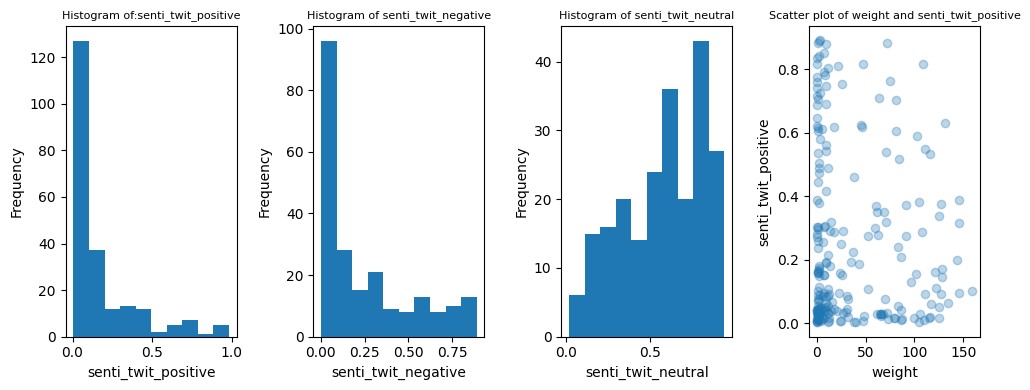

In [998]:
## ARE HIGHEST WEIGHTING DUE TO STRONGEST SENTIMENT ? -- NO (whew). 
#dict_df_window_wgt[120].keys()

df_temp = dict_df_window_wgt[120][pd.to_datetime('2024-01-01 00:00:00')]
# get dict value as above but as a pandas dataframe
df_temp = pd.DataFrame(df_temp).copy()

# plot df_reddit columns in scatter
var_a = 'senti_twit_positive'
var_b = 'senti_twit_negative'
var_c = 'senti_twit_neutral'
var_d = 'weight'

fig, axs = plt.subplots(1, 4, figsize=(10, 4))  # Create a figure with two subplots

# var_a
axs[0].hist(df_temp[var_a]) 
axs[0].set_xlabel(var_a)
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of:' + var_a, fontsize=8)

# var_b
axs[1].hist(df_temp[[var_b]])
axs[1].set_xlabel(var_b)
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of ' + var_b, fontsize=8)

# var_c
axs[2].hist(df_temp[[var_c]])
axs[2].set_xlabel(var_c)
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of ' + var_c, fontsize=8)


# are higher weighted posts due to stronger sentiment ?
# var_d, var_a scatter
axs[3].scatter(df_temp[var_d], df_temp[var_b], alpha=0.3)
axs[3].set_xlabel(var_d)
axs[3].set_ylabel(var_a)
axs[3].set_title('Scatter plot of ' + var_d + ' and ' + var_a, fontsize=8)


plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [999]:
# check what gets weighted high vs low
dict_df_window_wgt[120]

# show key within dict_df_window_wgt[120]
#dict_df_window_wgt[120].keys()

df_temp = dict_df_window_wgt[120][pd.to_datetime('2024-01-01 00:00:00')].copy()
#print(df_temp.columns)
temp_col_list = ['weight', 'selftext'] + [col for col in df_temp.columns if 'senti_twit' in col]

df_temp = df_temp[temp_col_list].copy()
df_temp
print(df_temp.weight.sum())
print('if equal wgt,', round(1/df_temp.shape[0], 5))
df_temp['weight_normalized'] = df_temp['weight'] / df_temp['weight'].sum()
print('weight normalized, dataset range:', round(df_temp.weight_normalized.min(), 5), round(df_temp.weight_normalized.max(),5))

# multiple weight to all other columns and create columns with suffix _wgt
df_temp_wgt = df_temp.copy()
#df_temp_wgt.columns = [col + '_wgt' for col in df_temp_wgt.columns]
#df_temp_wgt.weight = df_temp.weight.copy()
#df_temp_wgt = pd.concat([df_temp.weight_normalized, df_temp.selftext, df_temp.loc[:, ~df_temp.columns.str.contains('|'.join(['weight_normalized', 'selftext']))].mul(df_temp['weight'], axis=0)/df_temp['weight'].sum()], axis=1)
df_temp_wgt = pd.concat([df_temp.weight_normalized, df_temp.selftext, df_temp.loc[:, ~df_temp.columns.str.contains('|'.join(['weight', 'selftext']))].mul(df_temp['weight_normalized'], axis=0)], axis=1)

df_temp_wgt

df_temp_wgt.sort_values(by='weight_normalized', ascending=False).head(10)


7848.925485794292
if equal wgt, 0.004524886877828055


,weight_normalized,selftext,senti_twit_negative,senti_twit_neutral,senti_twit_positive,senti_twit_dir
3377,0.020289,My wife randomly asked how Bitcoin was doing the other day. I explained about the pending ETF and how it’s more than doubled in the last year. The next question was how much we had invested into it. She threw out a number £x. I murmured an agreement to this. In fact the actual amount invested is approx 12x greater. The conclusion of the conversation was that we should hold anyway (despite being in profit). My concern is if she knew the full amount she would apply pressure to sell it sooner. Obviously she will see the benefits of us holding further in the long term. How open with your other half are you about your BTC investments?,0.002067,0.015513,0.002710,0.0
3228,0.018557,"I've DCA for the past 3 years, 100% BTC+hardware wallet. I know other coins can give me better returns but i feel like i wanna stay 100% BTC in next bull run. Im just too scared to own other, feel like BTC is my safest asset.I think with those others i would be constantly worried about devs leaving, hacks, some rugpulls(even in top 100 alts) and that alts are basically companies and that they depend on central entity etc.. Been DCA for past 3 years, I have only 0.23 BTC and my average 23k so its not much but im from third world country so its hard to buy more..",0.001779,0.009339,0.007439,0.0
3386,0.018547,"As an OG hodler who has been mining since you could do it on a Pentium 4 desktop, with all the sincerity in my heart, OG's - SHUT UP. The entire ethos of bitcoin is that anyone can do what they want with their property. If noobs are excited about what bitcoin ETF's can do for this space, it's none of your business. All this growling about it is just out of order. You don't own Bitcoin Network. You are not special. Knock off the self-righteous criticism and dooming. If bitcoin is what we say it is, it won't matter anyway.",0.005833,0.009309,0.003405,0.0
3399,0.018519,"Ok, let’s say you’re third world country resident, have to travel international, escape dictatorship etc, surely a metal object will get attention when going through tsa, and worst case scenario could be confiscated for some arbitrary reason. What’s the safest way to get your seed phrase through hypothetical dictatorship customs aside from memorizing it?",0.007198,0.010741,0.000580,0.0
3409,0.018333,"1. Spot bitcoin ETF fully approved 2. The halving will be anti-climatic 3. The beginning of 'block-size wars 2.0' will begin in earnest, this time over bitcoin's censorship resistance around the dynamics of mining. It will initiate a serious bifurcation of bitcoiners that will cast doubt and confusion in the public markets; ""*leave it alone and let free markets play out*"" vs. ""*we must stop the graffiti or else bitcoin will ultimately fail"".* New mining pools will pop up all over with aggressive marketing on how they promote decentralized processes (block template selections, non-custodial payouts, stratum v2, etc...). This is going to be a hot area in 2024. 4. Do Kwon & Alex Mashinksy will stand trial and jury. No one will care much, as the damage has been already done. 5. NOST adoption will continue but be far slower that hoped for. It's bleeding edge, and still has a big learning curve and public education to overcome. It'll get there, but needs way more time. 6. No meaningful legislation that will hurt bitcoin in 2024. Lame duck congress, nothing will happen. 7. Trump will win 2024 US presidential election. This will result in headwinds on bitcoin for the next several years as he is a USD fiat maxi. 8. BitVM will grab some headlines on super interesting use cases, but fail to materialize due to technical complexity. This too needs more time, but will get there. 9. One more country will declare bitcoin legal tender. An island nation, with abundant natural resources and little debt to the IMF. 10. Saudi Arabia will start making meaningful transition away from selling oil in 

In [ ]:
df_temp_wgt.sort_values(by='weight_normalized', ascending=False).tail(10)

### Fields with Highest Correlation -- Wgting Scheme vs. Non Wgt
- What are the fields with highest correlation to target fwd return?
- Is our weighting scheme effective?

In [1000]:
df_model = df_merged.copy()

df_model.columns

target_field = 'ret_fwd_120_h'
#target_field = 'close_price'

df_corr = df_model.select_dtypes(include=['float32','float64', 'int64']).copy()
# only columns containing senti_twit
#df_corr = df_corr[[col for col in df_temp.columns if 'senti_twit_' in col]].copy()
df_corr = df_corr.corr()
df_corr = df_corr[[target_field]].reset_index(drop=False)
df_corr.sort_values([target_field], key = abs, ascending=False, inplace=True)
df_corr.rename(columns={'index': 'field', target_field: 'correl'}, inplace=True)

# drop fwd fields because unknown in point in time
df_corr = df_corr.loc[~df_corr.field.str.contains('ret_fwd_')].copy()

#print(df_temp_corr.loc[(df_temp_corr.correl > 0.25)].shape)
print('senti fields', df_corr.loc[(df_corr.correl > 0.4) & (df_corr.field.str.contains('senti'))].shape)
print('senti fields, wgt', df_corr.loc[(df_corr.correl > 0.4) & (df_corr.field.str.contains('senti')) & (df_corr.field.str.contains('wgt'))].shape)

# show fields containing 'ret_past'
df_corr.loc[df_corr.field.str.contains('ret_past')]

df_corr.head(20)

senti fields (10, 2)
senti fields, wgt (7, 2)


,field,correl
301,senti_emotions_optimism_rolling_wgt_w360,0.537377
169,senti_emotions_optimism_rolling_w360,0.536727
268,senti_emotions_optimism_rolling_wgt_w240,0.526987
307,senti_emotions_caring_rolling_wgt_w360,0.522888
136,senti_emotions_optimism_rolling_w240,0.503871
191,senti_emotions_pride_rolling_w360,0.474446
235,senti_emotions_optimism_rolling_wgt_w168,0.456026
315,senti_emotions_amusement_rolling_wgt_w360,0.434984
237,senti_emotions_excitement_rolling_wgt_w168,0.420631
204,senti_emotions_excitement_rolling_wgt_w120,0.410796


In [1030]:
# compare non-wgt vs wgt in top correlated fields
correl_threshold = 0.3
# get list of unique emotions
list_emotions_top = df_corr.loc[(abs(df_corr.correl) > correl_threshold) & 
                                 (df_corr.field.str.contains('senti_emotions'))].field.str.split('_').str[2].unique()
list_lookback_window_top = df_corr.field.str.extract(r'w(\d+)').dropna().astype(int).iloc[:,0].unique()
# create a dataframe to store the results
df_corr_diff = pd.DataFrame()

for emotion in list_emotions_top:
    for window in list_lookback_window_top:
        field = f'senti_emotions_{emotion}_rolling_w{window}'
        field_wgt = f'senti_emotions_{emotion}_rolling_wgt_w{window}'
        df_corr_diff = pd.concat([df_corr_diff, pd.DataFrame({'field': [field], 'correl': [df_corr.loc[df_corr.field == field].correl.values[0]],
                                                                        'field_wgt': [field_wgt], 'correl_wgt': [df_corr.loc[df_corr.field == field_wgt].correl.values[0]],
                                                                        'diff': [df_corr.loc[df_corr.field == field].correl.values[0] - df_corr.loc[df_corr.field == field_wgt].correl.values[0]]
                                                                        })], ignore_index=True)

# trim if neither have correl or correl_wgt are above threshold
df_corr_diff = df_corr_diff.loc[(abs(df_corr_diff.correl) > correl_threshold) | (abs(df_corr_diff.correl_wgt) > correl_threshold)].copy()

print('count pairs', df_corr_diff.shape)
print('count wgt better than non-wgt', df_corr_diff.loc[df_corr_diff['diff'] < 0].shape)

df_corr_diff.sort_values('correl_wgt', ascending=False).head(40)

# count number of .diff < 0


count pairs (20, 5)
count wgt better than non-wgt (14, 5)


,field,correl,field_wgt,correl_wgt,diff
0,senti_emotions_optimism_rolling_w360,0.536727,senti_emotions_optimism_rolling_wgt_w360,0.537377,-0.000650
1,senti_emotions_optimism_rolling_w240,0.503871,senti_emotions_optimism_rolling_wgt_w240,0.526987,-0.023116
4,senti_emotions_caring_rolling_w360,0.399568,senti_emotions_caring_rolling_wgt_w360,0.522888,-0.123320
2,senti_emotions_optimism_rolling_w168,0.352620,senti_emotions_optimism_rolling_wgt_w168,0.456026,-0.103406
12,senti_emotions_amusement_rolling_w360,0.323375,senti_emotions_amusement_rolling_wgt_w360,0.434984,-0.111610
18,senti_emotions_excitement_rolling_w168,0.146412,senti_emotions_excitement_rolling_wgt_w168,0.420631,-0.274219
19,senti_emotions_excitement_rolling_w120,0.165092,senti_emotions_excitement_rolling_wgt_w120,0.410796,-0.245704
3,senti_emotions_optimism_rolling_w120,0.246310,senti_emotions_optimism_rolling_wgt_w120,0.394747,-0.148437
24,senti_emotions_admiration_rolling_w360,0.292079,senti_emotions_admiration_rolling_wgt_w360,0.373678,-0.081598
17,senti_emotions_excitement_rolling_w240,0.089437,senti_emotions_excitement_rolling_wgt_w240,0.311597,-0.222160


correl fwd_ret vs. senti_emotions_optimism_rolling_w360 :  0.5367
correl fwd_ret vs. senti_emotions_optimism_rolling_wgt_w360 :  0.5374
correl fwd_ret vs.diff senti_emotions_optimism_rolling_w360 :  0.264
correl fwd_ret vs.pct chg senti_emotions_optimism_rolling_w360 :  0.1974


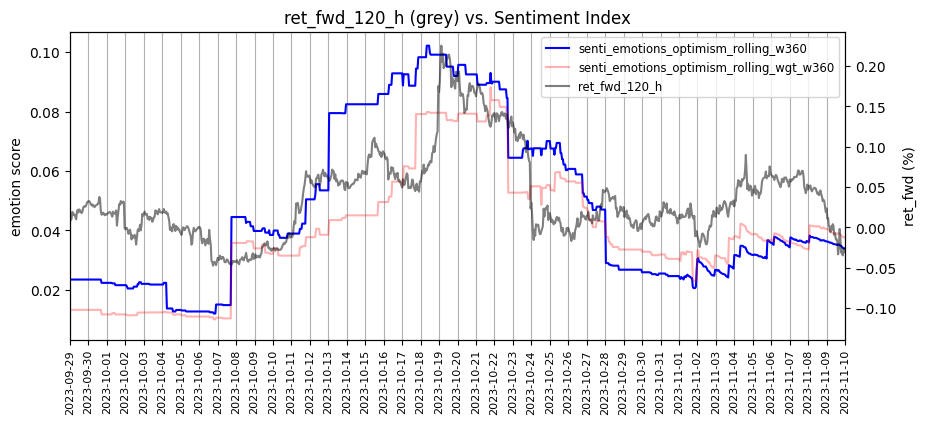

In [1180]:
# Plot two columns in a line chart
#field_a = 'senti_emotions_love_rolling_wgt_w240'
#field_b = 'senti_emotions_love_rolling_w240'
field_a = 'senti_emotions_optimism_rolling_w360'
field_b = 'senti_emotions_optimism_rolling_wgt_w360'
target_field = 'ret_fwd_120_h'
#target_field = 'close_price'

print('correl fwd_ret vs.', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a]),4))
print('correl fwd_ret vs.', field_b, ': ', round(df_model[target_field].corr(df_merged[field_b]),4))
print('correl fwd_ret vs.diff', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a].diff(24*5)),4))
print('correl fwd_ret vs.pct chg', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a].pct_change(24*5)),4))

plt.figure(figsize=(10, 4))

# Plot the first dataset
ax1 = plt.gca()
ax1.plot(df_model.timestamp, df_model[field_a], label=field_a, color='blue', alpha=1)
ax1.plot(df_model.timestamp, df_model[field_b], label=field_b, color='red', alpha=0.3)
ax1.set_ylabel('emotion score', fontsize=10)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_model.timestamp, df_model[target_field], label=target_field, color='black', alpha=0.5)
ax2.set_ylabel('ret_fwd (%)', fontsize=10)

# Show legend and title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right', fontsize='small')


# zoom
zoom_start = pd.to_datetime(df_model.timestamp.min())
zoom_end = pd.to_datetime(df_model.timestamp.max())
#zoom_start = pd.to_datetime('2023-10-15')
#zoom_end = pd.to_datetime('2023-10-31')
zoom_start = pd.to_datetime('2023-09-29')
zoom_end = pd.to_datetime('2023-11-10')
ax1.set_xlim([zoom_start, zoom_end])  # Replace start_date and end_date with your desired date range

# x-axis ticks
x_ticks = pd.date_range(start=zoom_start, end=zoom_end, freq='1D')  # Adjust the frequency as needed
plt.xticks(x_ticks)  # Set the font size of the tick labels
ax1.xaxis.set_tick_params(labelsize=8, rotation = 90)  # Set the font size of the x-axis tick labels
ax1.xaxis.grid()

# y-axis
#ax1.set_ylim([0, 0.08])  # Set the range of the y-axis
#ax2.set_ylim([-0.15, 0.1])  # Set the range of the y-axis

plt.title(target_field + ' (grey) vs. Sentiment Index', fontsize=12)  # Set the font size of the title
plt.show()

correl fwd_ret vs. senti_emotions_excitement_rolling_wgt_w120 :  0.4108
correl fwd_ret vs. senti_emotions_excitement_rolling_w120 :  0.1651
correl fwd_ret vs.diff senti_emotions_excitement_rolling_wgt_w120 :  0.2345
correl fwd_ret vs.pct chg senti_emotions_excitement_rolling_wgt_w120 :  0.2419


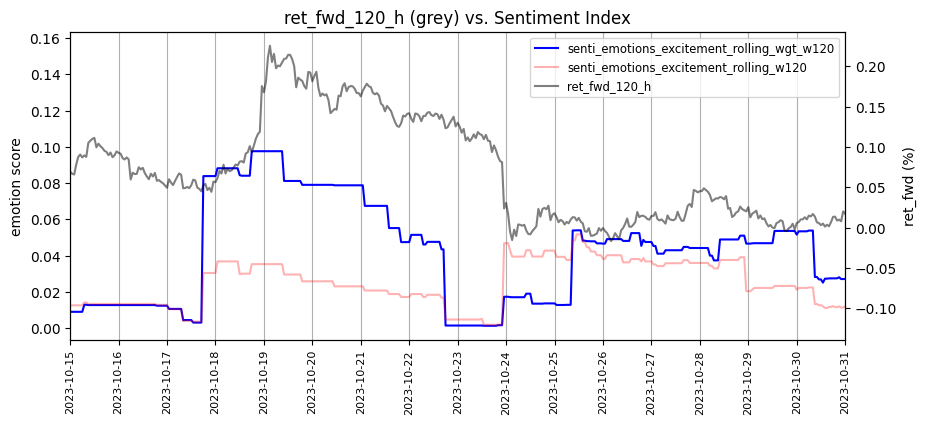

In [1051]:
# Plot two columns in a line chart
field_a = 'senti_emotions_excitement_rolling_wgt_w120'
field_b = 'senti_emotions_excitement_rolling_w120'

#field_a = 'volatility_120_h'
#field_b = 'volatilityEMA_120_h'

#field_a = 'senti_sub_freq_rolling_w120'
#field_b = 'senti_sub_freq_rolling_timeDecay_w120'

target_field = 'ret_fwd_120_h'
#target_field = 'close_price'

print('correl fwd_ret vs.', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a]),4))
print('correl fwd_ret vs.', field_b, ': ', round(df_model[target_field].corr(df_merged[field_b]),4))
print('correl fwd_ret vs.diff', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a].diff(24*5)),4))
print('correl fwd_ret vs.pct chg', field_a, ': ', round(df_model[target_field].corr(df_merged[field_a].pct_change(24*5)),4))

plt.figure(figsize=(10, 4))

# Plot the first dataset
ax1 = plt.gca()
ax1.plot(df_model.timestamp, df_model[field_a], label=field_a, color='blue', alpha=1)
ax1.plot(df_model.timestamp, df_model[field_b], label=field_b, color='red', alpha=0.3)
ax1.set_ylabel('emotion score', fontsize=10)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_model.timestamp, df_model[target_field], label=target_field, color='black', alpha=0.5)
ax2.set_ylabel('ret_fwd (%)', fontsize=10)

# Show legend and title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right', fontsize='small')


# zoom
zoom_start = pd.to_datetime('2023-10-15')
zoom_end = pd.to_datetime('2023-10-31')
#zoom_start = df_model.timestamp.min()
#zoom_end = df_model.timestamp.max()
ax1.set_xlim([zoom_start, zoom_end])  # Replace start_date and end_date with your desired date range

# x-axis ticks
x_ticks = pd.date_range(start=zoom_start, end=zoom_end, freq='1D')  # Adjust the frequency as needed
plt.xticks(x_ticks)  # Set the font size of the tick labels
ax1.xaxis.set_tick_params(labelsize=8, rotation = 90)  # Set the font size of the x-axis tick labels
ax1.xaxis.grid()

plt.title(target_field + ' (grey) vs. Sentiment Index', fontsize=12)  # Set the font size of the title
plt.show()


# Modeling

### FUNCTIONS: 
series_to_supervised -- prepare data

selectDataColumns

runModel v2

In [1172]:
def selectDataColumns(df, ret_fwd_target = 'ret_fwd_120_h', 
                      time_steps = 24*5,
                      corr_threshold = 0.2,
                      price = True, naive = False,
                      ret_past=False, volume=False, trdCnt=False, 
                      senti_sub = False,
                      senti_emotions=False, senti_twit=True):
    # column selection from correlation results
    df_corr = df.select_dtypes(include=['float32','float64', 'int64']).copy()
    df_corr = df.corr()
    # find correlations to column field 'ret_fwd_120_h', and sort by absolute value
    df_corr = df_corr[ret_fwd_target].sort_values(key = abs, ascending=False).copy()
    # create list of columns that have absolute value correlation
    list_corr = df_corr_ret[abs(df_corr_ret) > corr_threshold].index.to_list()
    list_corr += ['timestamp', ret_fwd_target]
    
    # list from manually set parameters
    data_cols = ['timestamp']
    data_cols += [ret_fwd_target]
    if price:
        data_cols += [col for col in df.columns if 'close_price' in col]
    if ret_past:
        data_cols += [col for col in df.columns if 'ret_past_' in col]
        #data_cols += [col for col in df.columns if 'ret_past_120_h' in col]
    if volume:
        data_cols += [col for col in df.columns if 'vol' in col]
    if trdCnt:
        data_cols += [col for col in df.columns if 'trdCnt' in col]
    if senti_sub:
        data_cols += [col for col in df.columns if 'senti_sub_' in col]
    if senti_emotions:
        data_cols += [col for col in df.columns if 'senti_emotions_' in col]
    if senti_twit:
        data_cols += [col for col in df.columns if 'senti_twit_' in col]
    
    # find intersection of columns from correlation and manual selection
    data_cols = list(set(data_cols).intersection(list_corr))
    
    # add naive ret_past if not in data_cols
    if naive:
        target_field_num = int(str(ret_fwd_target).split('_')[-2])
        target_field_past = 'ret_past_' + str(target_field_num) + '_h'
        # check if target_field_past is in data_cols
        if target_field_past not in data_cols:
            data_cols += [target_field_past]
    
    # make first element 'timestamp'
    data_cols.remove('timestamp')
    data_cols.remove(ret_fwd_target)
    data_cols = ['timestamp', ret_fwd_target] + data_cols
    #print(data_cols)
    return data_cols, time_steps



#### MODEL V2

In [1052]:
# prepare data for lstm

seed_value = 42
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    tf.random.set_seed(seed_value)
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg, agg.index.tolist()



In [1455]:
reframed_index = []
def runModel_v2(df, data_cols, split_ratio, time_steps):
    print('start')
    tf.random.set_seed(seed_value)
    keras.utils.set_random_seed(seed_value)
    
    data_raw = df[data_cols].copy()
    # make column into index
    data_raw.set_index('timestamp', inplace=True)
    
    # load dataset
    dataset = data_raw.copy()

    """
    this code is meant to use t-1 to predict t
    however, our data has the to predict value in same time row as the predictors
    therefore, shift the target column by 1
    and then drop the last row
    """
    # target column is the first column
    dataset[data_cols[1]] = dataset[data_cols[1]].shift(-1)
    # trim NaNs
    dataset.dropna(inplace=True)
    values = dataset.values
    values = values.astype('float32')
    # scale
    scaler = StandardScaler()
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    

    n_features = data_raw.shape[1]
    reframed, reframed_index = series_to_supervised(scaled, time_steps, 1)

    values = reframed.values
    n_train_hours = int(round(data_raw.shape[0]*split_ratio, 0))
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    reframed_index_train = reframed_index[:n_train_hours]
    reframed_index_test = reframed_index[n_train_hours:]

    n_obs = time_steps * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    train_X = np.delete(train_X, np.s_[::n_features], axis=1) # Remove target column from train_X
    # split into train and validation
    #train_X, train_y, val_X, val_y = train_test_split(train_X, train_y, test_size=0.2, shuffle = False, random_state=seed_value)

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    test_X = np.delete(test_X, np.s_[::n_features], axis=1)     # Remove target columns from test_X
    
    # check scaling of train_X by showing min and max of each column
    #print('train_X min:', train_X.min(axis=0))
    #print('train_X max:', train_X.max(axis=0))
    # n_features has changed!!
    n_features = n_features - 1
    #print('n_features:', n_features)
    train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))
    #val_X = val_X.reshape((val_X.shape[0], time_steps, n_features))
    test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))

    model = Sequential([
        #layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', 
        #            kernel_regularizer = regularizers.l2(0.0001),
        #            recurrent_regularizer = regularizers.l2(0.0001),
        #            return_sequences=True, 
        #            name='layer1'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.2),
        #layers.LSTM(32, name='layer2'),
        #layers.LSTM(64, name='layer3'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.2),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dense(64, activation='relu', name='dense2'),
        layers.Dense(1, activation='relu', name='output')
    ])

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='loss', patience=3, mode='auto', verbose = 1, restore_best_weights = True
        )

    def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        #loss='mean_squared_error',
        loss = 'mean_absolute_error',
        #loss=root_mean_squared_error,
        metrics = ['mse', 'mae', 'mape'], # accuracy
        optimizer=optimizer,
        run_eagerly=True
    )

    history = model.fit(train_X, train_y, epochs=100, batch_size=256, validation_data=(test_X, test_y), 
                        verbose=1, shuffle=False,
                        callbacks=[early_stopping]
                        )

    # plot history
    #plt.plot(history.history['loss'], label='train')
    #plt.plot(history.history['val_loss'], label='test')
    #plt.legend()
    #plt.show()
    

    ## PERFORMANCE METRICS

    # RMSE of train
    yhat_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], time_steps*n_features))
    print('train_X shape:', train_X.shape)
    print('yhat_train shape:', yhat_train.shape)
    print('num ffeatures:', n_features)
    inv_yhat_train = concatenate((yhat_train, train_X[:, -(n_features):]), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = concatenate((train_y, train_X[:, -(n_features):]), axis=1)
    inv_y_train = scaler.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:,0]
    # calculate RMSE of model
    rmse_train = math.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    print('Train RMSE: %.6f' % rmse_train)

    # RMSE OF TEST
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], time_steps*n_features))
    # undo scaling
    inv_yhat = concatenate((yhat, test_X[:, -(n_features):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE of model
    rmse_test = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.6f' % rmse_test)


    ## RMSE OF NAIVE
    # naive method is yhat = y(t-1)
    #get number in the column name ret_fwd_###_h
    target_field_num = int(str(data_cols[1]).split('_')[-2])
    target_field_past = 'ret_past_' + str(target_field_num) + '_h'
    # check if target_field_past is in data_cols
    if target_field_past in data_cols:
        # from dataset, get last rows based on test_y shape
        inv_yhat_naive = dataset[target_field_past]
        inv_yhat_naive = dataset[target_field_past].values[-test_y.shape[0]:]
        inv_y_naive = dataset[data_cols[1]].values[-(test_y.shape[0]+1):]
        # shift inv_y_naive by 1 and drop first row
        inv_y_naive = inv_y_naive[1:]
        #print('inv yhat naive shape', inv_yhat_naive.shape)
        rmse_naive = math.sqrt(mean_squared_error(inv_y_naive, inv_yhat_naive))
    else:
        inv_y_naive = np.nan
        inv_yhat_naive = np.nan
        rmse_naive = np.nan
    #print('test naive RMSE: %.6f' % rmse_naive)

    return history, yhat, test_X, inv_y, inv_yhat, \
        inv_y_train, inv_yhat_train, \
        inv_y_naive, inv_yhat_naive, \
            rmse_train, rmse_test, rmse_naive, \
                history.history['loss'], history.history['val_loss'],\
                    reframed_index_train, reframed_index_test



#### RUN MODEL V2

In [1456]:
# RUN MODEL

# Define the parameter combinations
parameters = [
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.0, # force Naive
     'price': False, 'naive': True, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': False},

    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.0, # only ret_past
     'price': False, 'naive': False, 'ret_past': True, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': True},

     {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.0, # only senti_emotions
     'price': False, 'naive': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': True, 'senti_twit': False},

     {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.3, # only senti_emotion, correl thresh
     'price': False, 'naive': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': True, 'senti_twit': False},

     {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.0, # only senti_twit
     'price': False, 'naive': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': True},

     {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.3, # only senti_twit, correl thresh
     'price': False, 'naive': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': True}
]

parameters = [
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*1, 'corr_threshold': 0.0, # force Naive
     'price': False, 'naive': True, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': False},
{'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*1, 'corr_threshold': 0.15, # only senti_twit, correl thresh
     'price': True, 'naive': True, 'ret_past': True, 'volume': True, 'trdCnt': True, 
     'senti_sub': True, 'senti_emotions': True, 'senti_twit': True}]

# Create an empty dataframe to store the results
df_results = pd.DataFrame(columns=['RMSE_test', 'RMSE_train', 'RMSE_naive', *parameters[0].keys()])

# choose df
df_model = df_merged.copy()

reframed = pd.DataFrame()

# Loop through the parameter combinations
for params in parameters:
    # Get the data columns based on the current parameter combination
    data_cols, time_steps = selectDataColumns(df_model, **params)

    # Run the model and get the RMSE
    _, _, _, inv_y, inv_yhat, \
        inv_y_train, inv_yhat_train, \
        inv_y_naive, inv_yhat_naive, rmse_train, rmse_test, rmse_naive, \
            history_loss, history_val_loss, \
                _, _, = runModel_v2(df_model, data_cols, split_ratio=0.8, time_steps=time_steps)
    
    # concat results to the dataframe
    df_results = pd.concat([df_results, pd.DataFrame({
        'RMSE_test': [rmse_test], 'RMSE_train': [rmse_train], 'RMSE_naive': [rmse_naive], 
        **params,
        'inv_y': [inv_y], 'inv_yhat': [inv_yhat], 'data_cols': [data_cols],
        'inv_y_train': [inv_y_train], 'inv_yhat_train': [inv_yhat_train],
        'history_loss': [history_loss], 'history_val_loss': [history_val_loss]
        })], ignore_index=True)

df_results['RMSE_decay'] = round((df_results['RMSE_test']/df_results['RMSE_naive'] - 1)*100, 2)

pd.set_option('display.max_colwidth', 50)
df_results

start
Epoch 1/100
14/14 [==============================] - 2s 140ms/step - loss: 0.6420 - mse: 0.9061 - mae: 0.6386 - mape: 116.3947 - val_loss: 0.9630 - val_mse: 1.4666 - val_mae: 0.9596 - val_mape: 107.2722
Epoch 2/100
14/14 [==============================] - 2s 125ms/step - loss: 0.6407 - mse: 0.9082 - mae: 0.6373 - mape: 110.4299 - val_loss: 0.9587 - val_mse: 1.4588 - val_mae: 0.9554 - val_mape: 104.6762
Epoch 3/100
14/14 [==============================] - 2s 131ms/step - loss: 0.6401 - mse: 0.9103 - mae: 0.6368 - mape: 106.3368 - val_loss: 0.9555 - val_mse: 1.4533 - val_mae: 0.9523 - val_mape: 102.8135
Epoch 4/100
14/14 [==============================] - 2s 125ms/step - loss: 0.6398 - mse: 0.9117 - mae: 0.6366 - mape: 103.9370 - val_loss: 0.9537 - val_mse: 1.4499 - val_mae: 0.9505 - val_mape: 101.7016
Epoch 5/100
14/14 [==============================] - 2s 124ms/step - loss: 0.6396 - mse: 0.9124 - mae: 0.6365 - mape: 102.7285 - val_loss: 0.9527 - val_mse: 1.4482 - val_mae: 0.9496 

/var/folders/y_/p9bqtzbd0cd4xvrfxg_r0r180000gn/T/ipykernel_75847/1529475356.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame({


start
Epoch 1/100
14/14 [==============================] - 2s 140ms/step - loss: 0.7157 - mse: 1.0211 - mae: 0.6998 - mape: 187.4767 - val_loss: 1.0038 - val_mse: 1.5305 - val_mae: 0.9879 - val_mape: 132.0341
Epoch 2/100
14/14 [==============================] - 2s 136ms/step - loss: 0.6794 - mse: 0.9632 - mae: 0.6635 - mape: 147.1649 - val_loss: 0.9985 - val_mse: 1.5186 - val_mae: 0.9826 - val_mape: 129.0140
Epoch 3/100
14/14 [==============================] - 2s 138ms/step - loss: 0.6570 - mse: 0.9285 - mae: 0.6411 - mape: 124.9835 - val_loss: 0.9956 - val_mse: 1.5119 - val_mae: 0.9797 - val_mape: 127.6292
Epoch 4/100
14/14 [==============================] - 2s 140ms/step - loss: 0.6402 - mse: 0.9039 - mae: 0.6243 - mape: 115.6972 - val_loss: 0.9956 - val_mse: 1.5113 - val_mae: 0.9797 - val_mape: 127.7794
Epoch 5/100
14/14 [==============================] - 2s 137ms/step - loss: 0.6288 - mse: 0.8866 - mae: 0.6129 - mape: 111.1850 - val_loss: 0.9977 - val_mse: 1.5153 - val_mae: 0.9818 

,RMSE_test,RMSE_train,RMSE_naive,ret_fwd_target,time_steps,corr_threshold,price,naive,ret_past,volume,trdCnt,senti_sub,senti_emotions,senti_twit,inv_y,inv_yhat,data_cols,inv_y_train,inv_yhat_train,history_loss,history_val_loss,RMSE_decay
0,0.055312,0.042992,0.080986,ret_fwd_120_h,24,0.00,False,True,False,False,False,False,False,False,"[0.0065387874, 0.008286956, 0.011127207, 0.009...","[0.010120813, 0.010120813, 0.010120813, 0.0101...","[timestamp, ret_fwd_120_h, ret_past_120_h]","[0.029179383, 0.02064207, 0.024997063, 0.01059...","[0.010120813, 0.010120813, 0.010120813, 0.0101...","[0.6420273184776306, 0.6406720876693726, 0.640...","[0.962989330291748, 0.9586738348007202, 0.9555...",-31.70
1,0.060062,0.029536,0.080986,ret_fwd_120_h,24,0.15,True,True,True,True,True,True,True,True,"[0.0065387874, 0.008286956, 0.011127207, 0.009...","[0.010120813, 0.010120813, 0.010120813, 0.0101...","[timestamp, ret_fwd_120_h, senti_emotions_exci...","[0.029179383, 0.02064207, 0.024997063, 0.01059...","[0.030663993, 0.029288398, 0.022098005, 0.0147...","[0.7156745791435242, 0.6794421076774597, 0.656...","[1.0037802457809448, 0.998487114906311, 0.9956...",-25.84


#### PLOT RESULTS

In [1457]:
# change display settings so column width is limited
pd.set_option('display.max_colwidth', 50)
# how to limit 
df_results

df_results[['inv_y', 'inv_yhat', 'inv_y_train', 'inv_yhat_train']]

# plot the results


#pd.set_option('display.max_colwidth', None)
#df_results.data_cols.to_list()

#[0.010120813, 0.010120813, 0.010120813, 0.0101

,inv_y,inv_yhat,inv_y_train,inv_yhat_train
0,"[0.0065387874, 0.008286956, 0.011127207, 0.009...","[0.010120813, 0.010120813, 0.010120813, 0.0101...","[0.029179383, 0.02064207, 0.024997063, 0.01059...","[0.010120813, 0.010120813, 0.010120813, 0.0101..."
1,"[0.0065387874, 0.008286956, 0.011127207, 0.009...","[0.010120813, 0.010120813, 0.010120813, 0.0101...","[0.029179383, 0.02064207, 0.024997063, 0.01059...","[0.030663993, 0.029288398, 0.022098005, 0.0147..."


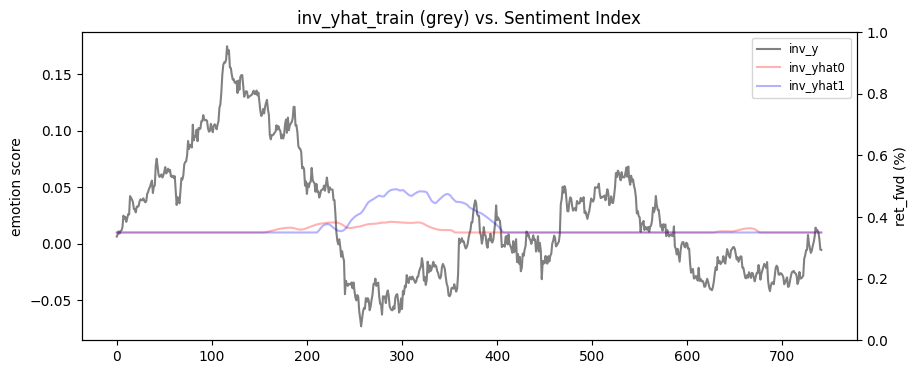

In [1458]:
# Plot two columns in a line chart
field_a = 'inv_y'
field_b = 'inv_yhat'

target_field = 'inv_yhat_train'

i = 0

#print('correl fwd_ret vs.', field_a, ': ', round(df_results[target_field].corr(df_results[field_a]),4))
#print('correl fwd_ret vs.', field_b, ': ', round(df_results[target_field].corr(df_results[field_b]),4))
#print('correl fwd_ret vs.diff', field_a, ': ', round(df_results[target_field].corr(df_results[field_a].diff(24*5)),4))
#print('correl fwd_ret vs.pct chg', field_a, ': ', round(df_results[target_field].corr(df_results[field_a].pct_change(24*5)),4))

plt.figure(figsize=(10, 4))

# Plot the first dataset
ax1 = plt.gca()
ax1.plot(df_results[field_a][i], label=field_a, color='grey', alpha=1)
ax1.plot(df_results[field_b][i], label=field_b+'0', color='red', alpha=0.3)
ax1.plot(df_results[field_b][i+1], label=field_b+'1', color='blue', alpha=0.3)
ax1.set_ylabel('emotion score', fontsize=10)

# Create a second y-axis
ax2 = ax1.twinx()
#ax2.plot(df_results[target_field][i], label=target_field, color='black', alpha=0.5)
ax2.set_ylabel('ret_fwd (%)', fontsize=10)


# Show legend and title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right', fontsize='small')


# zoom
#zoom_start = pd.to_datetime('2023-10-15')
#zoom_end = pd.to_datetime('2023-10-31')
#zoom_start = df_model.timestamp.min()
#zoom_end = df_model.timestamp.max()
#ax1.set_xlim([zoom_start, zoom_end])  # Replace start_date and end_date with your desired date range

# x-axis ticks
#x_ticks = pd.date_range(start=zoom_start, end=zoom_end, freq='1D')  # Adjust the frequency as needed
#plt.xticks(x_ticks)  # Set the font size of the tick labels
#ax1.xaxis.set_tick_params(labelsize=8, rotation = 90)  # Set the font size of the x-axis tick labels
#ax1.xaxis.grid()

plt.title(target_field + ' (grey) vs. Sentiment Index', fontsize=12)  # Set the font size of the title
plt.show()



array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'ret_fwd_120_h'}>,
        <Axes: title={'center': 'senti_emotions_excitement_rolling_wgt_timeDecay_w120'}>,
        <Axes: title={'center': 'senti_emotions_disapproval_rolling_wgt_w168'}>,
        <Axes: title={'center': 'senti_emotions_amusement_rolling_wgt_w360'}>,
        <Axes: title={'center': 'senti_emotions_admiration_rolling_wgt_w120'}>,
        <Axes: title={'center': 'senti_emotions_embarrassment_rolling_wgt_w240'}>,
        <Axes: title={'center': 'senti_emotions_disappointment_rolling_w360'}>,
        <Axes: title={'center': 'trdCnt_72_h'}>,
        <Axes: title={'center': 'senti_emotions_desire_rolling_w240'}>,
        <Axes: title={'center': 'senti_twit_dir_rolling_wgt_w120'}>],
       [<Axes: title={'center': 'senti_emotions_remorse_rolling_wgt_w168'}>,
        <Axes: title={'center': 'senti_emotions_sadness_rolling_w168'}>,
        <Axes: title={'center': 'senti_emotions_nervousness_rolling_

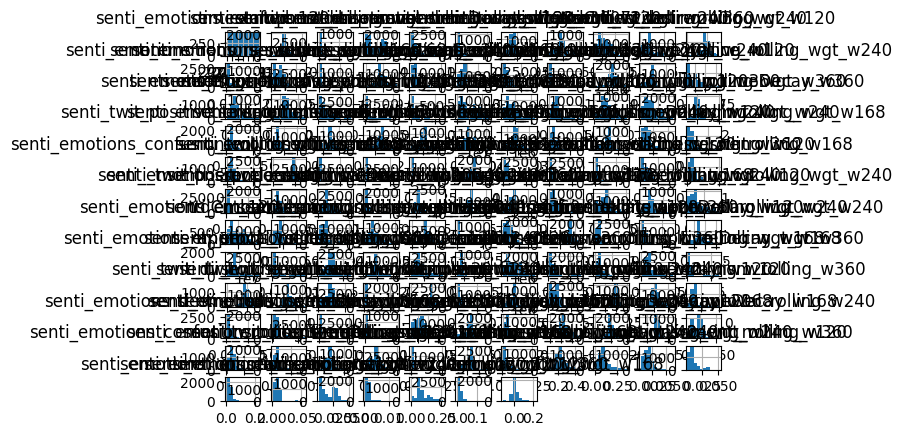

# MISC

sources:

https://www.kaggle.com/code/yassinesfaihi/lstm-s-p500-stocks-time-series-forecasting

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://www.kaggle.com/code/gurpreetmohaar/time-series-forecasting-using-lstm

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

https://pypi.org/project/time-series-generator/

https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

https://www.kaggle.com/code/ritesh7355/develop-lstm-models-for-time-series-forecasting

https://www.kaggle.com/code/sasakitetsuya/multivariate-time-series-forecasting-with-lstms

https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
## RUN MODEL V1

"""
reframed_index = []
def runModel(df, data_cols, split_ratio, time_steps):
    tf.random.set_seed(seed_value)
    keras.utils.set_random_seed(seed_value)
    
    data_raw = df[data_cols].copy()

    # make column into index
    data_raw.set_index('timestamp', inplace=True)

    # load dataset
    dataset = data_raw.copy()
    values = dataset.values
    values = values.astype('float32')
    scaler = StandardScaler()
    scaled = scaler.fit_transform(values)

    n_features = data_raw.shape[1]
    reframed, reframed_index = series_to_supervised(scaled, time_steps, 1)

    values = reframed.values
    n_train_hours = int(round(data_raw.shape[0]*split_ratio, 0))
    train = values[:n_train_hours, :]
    print('train shape', train.shape)
    test = values[n_train_hours:, :]
    print('test shape', test.shape)

    reframed_index_train = reframed_index[:n_train_hours]
    reframed_index_test = reframed_index[n_train_hours:]
    #print('reframed_index_train', len(reframed_index_train))
    #print('reframed_index_test', len(reframed_index_test))

    n_obs = time_steps * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))
    test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))


    model = Sequential([
        layers.LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', return_sequences=True, 
                    name='layer1'),
        layers.LSTM(4, name='layer2'),
        layers.Dropout(0.2),
        #layers.Dense(25, activation='relu', name='dense1'),
        layers.Dense(1, activation='relu', name='output')
    ])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

    def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))
    model.compile(
        #loss='mean_squared_error',
        loss=root_mean_squared_error,
        metrics = ["accuracy"],
        optimizer='adam',
        run_eagerly=True
    )

    history = model.fit(train_X, train_y, epochs=2, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False#
                        #callbacks=[early_stopping]
                        )

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], time_steps*n_features))

    # undo scaling
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    #print('y pred, unscaled:', inv_yhat[-5:-1])
    
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    #print('y, unscaled:', inv_y[-5:-1])

    print('field', data_cols[1])
    #print('train shape', train_X.shape[0])
    #print('test shape', test_X.shape[0])
    
    # calculate RMSE of model
    # drop first five of inv_y and inv_yhat
    #inv_y = inv_y[5:]
    #inv_yhat = inv_yhat[5:]
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.6f' % rmse)

    # naive method is yhat = y(t-1)
    inv_yhat_naive = inv_y[:-120]
    inv_y_naive = inv_y[120:]
    rmse_naive = math.sqrt(mean_squared_error(inv_y_naive, inv_yhat_naive))
    print('test naive RMSE: %.6f' % rmse_naive)

    return history, yhat, test_X, inv_y, inv_yhat, inv_y_naive, inv_yhat_naive, rmse, rmse_naive, reframed_index_train, reframed_index_test



"""

In [ ]:
# RUN MODEL v1 for single parameter combination

"""
# single run method

df_model = df_merged.copy()

data_cols, _ = selectDataColumns(df_model, ret_fwd_target = 'ret_fwd_120_h',
                      price = True,
                      ret_past=True, volume=False, trdCnt=False, 
                      senti_sub = True,
                      senti_emotions=False, senti_twit=True)

history, yhat, test_X, inv_y, inv_yhat, \
    inv_y_naive, inv_yhat_naive, rmse, rmse_naive, \
         reframed_index_train, reframed_index_test = runModel(
             df_model, data_cols, split_ratio = 0.8, time_steps=24*10)
"""

# RUN MODEL V1 with loop for multiple parameter settings
"""
# Define the parameter combinations
parameters = [
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.2, # only itself , no other features
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': False},
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*10, 'corr_threshold': 0.2, 
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': False},
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*20, 'corr_threshold': 0.2, 
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': False, 'senti_twit': False},
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*5, 'corr_threshold': 0.2, # with senti_twit, senti_emotions
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': True, 'senti_twit': True},
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*10, 'corr_threshold': 0.2, 
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': True, 'senti_twit': True},
    {'ret_fwd_target': 'ret_fwd_120_h', 'time_steps': 24*20, 'corr_threshold': 0.2, 
     'price': False, 'ret_past': False, 'volume': False, 'trdCnt': False, 
     'senti_sub': False, 'senti_emotions': True, 'senti_twit': True}
    # Add more parameter combinations as needed
]

# Create an empty dataframe to store the results
df_results = pd.DataFrame(columns=['RMSE', *parameters[0].keys()])

# choose df
df_model = df_merged.copy()

# Loop through the parameter combinations
for params in parameters:
    # Get the data columns based on the current parameter combination
    data_cols, time_steps = selectDataColumns(df_model, **params)
    
    # Run the model and get the RMSE
    _, _, _, _, _, \
        _, _, rmse, _, \
             _, _, = runModel(df_model, data_cols, split_ratio=0.8, time_steps=time_steps)
    
    # concat results to the dataframe
    df_results = pd.concat([df_results, pd.DataFrame({'RMSE': [rmse], **params})], ignore_index=True)


# Print the results dataframe
df_results

"""


In [ ]:
## modelrun v2 with all print ccalls to test
"""
reframed_index = []
def runModel_v2(df, data_cols, split_ratio, time_steps):
    tf.random.set_seed(seed_value)
    keras.utils.set_random_seed(seed_value)
    
    data_raw = df[data_cols].copy()
    # make column into index
    data_raw.set_index('timestamp', inplace=True)
    print('data raw columns', data_raw.columns)

    
    #this code is meant to use t-1 to predict t
    #however, our data has the to predict value in same time row as the predictors
    #therefore, shift the target column by 1
    #and then drop the last row
    
    # target column is the first column
    #print(data_raw.head(5))
    data_raw[data_cols[1]] = data_raw[data_cols[1]].shift(-1)
    #print(data_raw.head(5))


    # load dataset
    dataset = data_raw.copy()
    # trim NaNs
    dataset.dropna(inplace=True)
    #print('dataframe shape', dataset.shape)
    values = dataset.values
    values = values.astype('float32')
    #print('values shape', values.shape)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(values)
    #print('values,scaled, shape', scaled.shape)

    n_features = data_raw.shape[1]
    reframed, reframed_index = series_to_supervised(scaled, time_steps, 1)
    #print('reframed shape', reframed.shape)
    #print('reframed columns', reframed.columns)
    print('reframed head', reframed.head(5))

    values = reframed.values
    n_train_hours = int(round(data_raw.shape[0]*split_ratio, 0))
    train = values[:n_train_hours, :]
    #print('train shape', train.shape)
    test = values[n_train_hours:, :]
    #print('test shape', test.shape)

    reframed_index_train = reframed_index[:n_train_hours]
    reframed_index_test = reframed_index[n_train_hours:]
    #print('reframed_index_train', len(reframed_index_train))
    #print('reframed_index_test', len(reframed_index_test))

    n_obs = time_steps * n_features
    #print('n_obs', n_obs)
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    # Remove target column from train_X
    train_X = np.delete(train_X, np.s_[::n_features], axis=1)

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # Remove target columns from test_X
    test_X = np.delete(test_X, np.s_[::n_features], axis=1)
    
    #print('train x shape, before reshape', train_X.shape)
    #print('train y shape, before reshape', train_y.shape)
    #print('test x shape, before reshape', test_X.shape)
    #print('test y shape, before reshape', test_y.shape)
    
    # n_features has changed!!
    n_features = n_features - 1
    train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))
    test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))
    #print('train x shape, after reshape', train_X.shape)
    #print('train y shape, after reshape', train_y.shape)
    #print('test x shape, after reshape', test_X.shape)
    #print('test y shape, after reshape', test_y.shape)

    model = Sequential([
        layers.LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', return_sequences=True, 
                    name='layer1'),
        layers.LSTM(4, name='layer2'),
        layers.Dropout(0.2),
        #layers.Dense(25, activation='relu', name='dense1'),
        layers.Dense(1, activation='relu', name='output')
    ])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

    def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))
    model.compile(
        #loss='mean_squared_error',
        loss=root_mean_squared_error,
        metrics = ["accuracy"],
        optimizer='adam',
        run_eagerly=True
    )

    history = model.fit(train_X, train_y, epochs=2, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False#
                        #callbacks=[early_stopping]
                        )

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], time_steps*n_features))
    print('yhat shape', yhat.shape)
    print('test_X shape, after undo - reshape', test_X.shape)

    # undo scaling
    #print('test X [:, -(n_features-1):] shape', test_X[:, -(n_features-1):].shape)
    #inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = concatenate((yhat, test_X[:, -(n_features):]), axis=1)
    #print('inv_yhat shape, BEFORE unscale', inv_yhat.shape)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    #print('inv_yhat[:0] shape', inv_yhat[:,0][0:5])
    #print('inv_yhat', inv_yhat[0:5,:])
    inv_yhat = inv_yhat[:,0]
    #print('y pred, unscaled:', inv_yhat[-5:-1])
    
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    #inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = concatenate((test_y, test_X[:, -(n_features):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    #print('y, unscaled:', inv_y[-5:-1])

    print('field', data_cols[1])
    #print('train shape', train_X.shape[0])
    print('test shape', test_X.shape[0])
    
    # calculate RMSE of model
    # drop first five of inv_y and inv_yhat
    #inv_y = inv_y[5:]
    #inv_yhat = inv_yhat[5:]
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.6f' % rmse)



    # naive method is yhat = y(t-1)
    #get number in the column name ret_fwd_###_h
    target_field_num = int(str(data_cols[1]).split('_')[-2])
    # find corresponding ret_past_###_h column and shift by 1
    target_field_past = 'ret_past_' + str(target_field_num) + '_h'
    inv_yhat_naive = dataset[target_field_past]
    # from dataset, get last rows based on test_y shape
    inv_y_naive = dataset[data_cols[1]].values[-test_y.shape[0]:]
    inv_yhat_naive = dataset[target_field_past].values[-test_y.shape[0]:]
    print('inv yhat naive shape', inv_yhat_naive.shape)
    #inv_yhat_naive = inv_y[:-120]
    #inv_y_naive = inv_y[120:]
    rmse_naive = math.sqrt(mean_squared_error(inv_y_naive, inv_yhat_naive))
    print('test naive RMSE: %.6f' % rmse_naive)

    return history, yhat, test_X, inv_y, inv_yhat, inv_y_naive, inv_yhat_naive, rmse, rmse_naive, reframed_index_train, reframed_index_test


"""

In [ ]:
## box plot code
"""
df_plot_box = df_reddit.copy()

plt.figure(figsize=(5, 4))
sns.boxplot(data = df_plot_box, x = 'score_quantile', y = 'upvote_ratio',
            showmeans = True, whis = 1.5, palette = 'Set1'
            )
plt.legend(title='senti_twit_dir', loc='upper right')
plt.title('Boxplot of ret_fwd_target by senti_twit_dir')
plt.xlabel('senti_twit_dir')
plt.ylabel('ret_fwd_target')
#plt.xticks(ticks = [0, 1, 2,3,4])# labels = ['Neutral', 'Positive', 'Negative'], rotation = 90)
#plt.gca().yaxis.set_major_locator(MultipleLocator(0.25))
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x_: '{:.1f}'.format(x)))
"""

In [ ]:
## PLOTTING CODE
"""
fig, ax1 = plt.subplots(figsize=(10, 6))

temp_field = 'senti_twit_negative_w24'

line1, = ax1.plot(df_merged['timestamp'], df_senti_rolling[temp_field], label='plain')
line2, = ax1.plot(df_merged['timestamp'], df_senti_rolling_wgt[temp_field], label='wgt')
#line3, = ax1.plot(df_merged_timeDecay['timestamp'], df_merged_timeDecay[temp_field], label='timeDecay')
#line4, = ax1.plot(df_merged_wgt_timeDecay['timestamp'], df_merged_wgt_timeDecay[temp_field], label='wgt, timeDecay')
ax1.set_xlabel('Datetime')
ax1.set_ylabel(temp_field)
ax1.set_title(temp_field)

# Create a second y-axis
#ax2 = ax1.twinx()
#line4, = ax2.plot(df_model['timestamp'], df_model['ret_fwd_120_h'], color='red', label='ret_fwd_120_h')
#ax2.set_ylabel('Return')

# Combine the legends
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels)

plt.show()

"""

"""
df_model = df_merged.copy()

df_model = df_model.reset_index(drop=True).copy()
# drop first 360 rows
df_model = df_model.iloc[360:,:].reset_index(drop=True).copy()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot sentiment lines
line1, = ax1.plot(df_model['timestamp'], df_model['senti_twit_negative_w24'], color = 'blue', alpha = 1, label='senti_twit_negative_w72')
#line2, = ax1.plot(df_model['timestamp'], df_model['senti_twit_neutral_w72'], label='senti_twit_neutral_w72')
#line3, = ax1.plot(df_model['timestamp'], df_model['senti_twit_positive_w72'], label='senti_twit_positive_w72')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Sentiment')
ax1.set_title('Sentiment Analysis')

# Create a second y-axis
ax2 = ax1.twinx()
line4, = ax2.plot(df_model['timestamp'], df_model['ret_fwd_120_h'], color='red', alpha = 0.5, label='ret_fwd_120_h')
ax2.set_ylabel('Return')

# Combine the legends
lines = [line1, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels)

plt.show()

"""



In [ ]:
## CORRELATION COMPARISON OF WEIGHTIING/TIME DECAY SCHEME
"""
list_lookback_window_str = [str(x) for x in list_lookback_window]
#senti_field = 'senti_twit_positive_w'
senti_field = 'senti_sub_freq_w'
#ret_field = 'ret_fwd_120_h'
ret_field = 'close_price'

correlation_df = pd.DataFrame(index=list_lookback_window_str, columns=['rolling', 'rolling_chg',
                                                                       'wgt', 'wgt_chg',
                                                                       'timeDecay', 'timeDecay_chg',
                                                                       'wgt_timeDecay', 'wgt_timeDecay_chg'])

# Calculate correlations for each lookback window
for window in list_lookback_window:
    senti_col = senti_field + str(window)
    correlation = df_merged[ret_field].corr(df_senti_rolling[senti_col])
    correlation_df.loc[str(window), 'rolling'] = round(correlation, 4)

# Calculate correlations for each lookback window with weighted average
for window in list_lookback_window:
    senti_col = senti_field + str(window)
    correlation = df_merged[ret_field].corr(df_senti_rolling_wgt[senti_col])
    correlation_df.loc[str(window), 'wgt'] = round(correlation, 4)


# Calculate correlations for each lookback window with time decay
for window in list_lookback_window:
    senti_col = senti_field + str(window)
    correlation = df_merged[ret_field].corr(df_senti_rolling_timeDecay[senti_col])
    correlation_df.loc[str(window), 'timeDecay'] = round(correlation, 4)


# Calculate correlations for each lookback window with weighted average and time decay
for window in list_lookback_window:
    senti_col = senti_field + str(window)
    correlation = df_merged[ret_field].corr(df_senti_rolling_wgt_timeDecay[senti_col])
    correlation_df.loc[str(window), 'wgt_timeDecay'] = round(correlation, 4)


correlation_df
"""

"""
# correl
df_model_floats = df_model.select_dtypes(include=['float32','float64', 'int64']).copy()
# drop senti_emotions_ columns
df_model_floats = df_model_floats.loc[:, ~df_model_floats.columns.str.startswith('senti_emotions_')]
# drop trdCnt
df_model_floats = df_model_floats.loc[:, ~df_model_floats.columns.str.startswith('trdCnt')]
# drop vol chg
df_model_floats = df_model_floats.loc[:, ~df_model_floats.columns.str.startswith('vol')]
# drop ret_past
df_model_floats = df_model_floats.loc[:, ~df_model_floats.columns.str.startswith('ret_past')]
plt.figure(figsize=(12, 12))
sns.heatmap(df_model_floats.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation Matrix of Model Data')
plt.show()

"""

In [541]:
from sklearn.model_selection import TimeSeriesSplit

reframed_index = []
def runModel(df, data_cols, split_ratio, time_steps):
    tf.random.set_seed(seed_value)
    keras.utils.set_random_seed(seed_value)
    
    data_raw = df[data_cols].copy()

    # make column into index
    data_raw.set_index('timestamp', inplace=True)

    # load dataset
    dataset = data_raw.copy()
    values = dataset.values
    values = values.astype('float32')
    scaler = StandardScaler()
    scaled = scaler.fit_transform(values)

    n_features = data_raw.shape[1]
    print(scaled.shape)
    reframed, reframed_index = series_to_supervised(scaled, time_steps, 1)
    print(reframed.shape)
    print(len(reframed_index))
    print(reframed_index[-20:])

    values = reframed.values

    tscv = TimeSeriesSplit(n_splits=2, gap = 120)
    for train_index, test_index in tscv.split(values):
        train = values[train_index]
        test = values[test_index]

        n_obs = time_steps * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]

        train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))
        test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))


        model = Sequential([
            layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', return_sequences=True, 
                        name='layer1'),
            layers.LSTM(32, name='layer2'),
            layers.Dropout(0.2),
            #layers.Dense(25, activation='relu', name='dense1'),
            layers.Dense(1, activation='relu', name='output')
        ])

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

        model.compile(
            loss='mean_squared_error',
            optimizer='adam',
            run_eagerly=True
        )

        history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks=[early_stopping])

        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], time_steps*n_features))

        # undo scaling
        inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        print('y pred, unscaled:', inv_yhat[-5:-1])
        
        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        #print('y, unscaled:', inv_y[-5:-1])

        print('field', data_cols[1])
        print('train shape', train_X.shape[0])
        print('test shape', test_X.shape[0])
        
        # calculate RMSE of model
        # drop first five of inv_y and inv_yhat
        #inv_y = inv_y[5:]
        #inv_yhat = inv_yhat[5:]
        rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.6f' % rmse)

        # naive method is yhat = y(t-1)
        inv_yhat_naive = inv_y[:-120]
        inv_y_naive = inv_y[120:]
        rmse_naive = math.sqrt(mean_squared_error(inv_y_naive, inv_yhat_naive))
        print('test naive RMSE: %.6f' % rmse_naive)

        return history, yhat, test_X, inv_y, inv_yhat, \
            inv_y_naive, inv_yhat_naive, rmse, rmse_naive


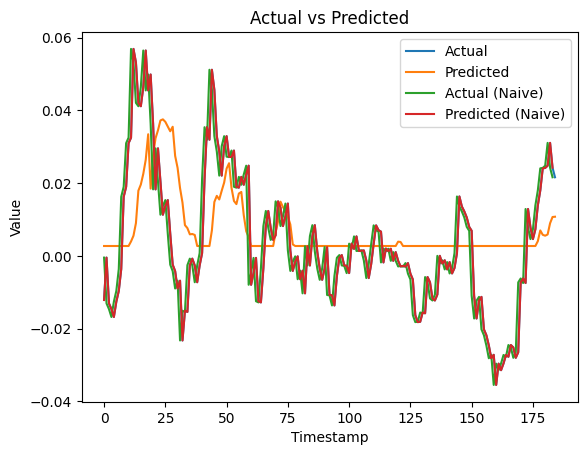

In [831]:
def plotPredVSNaive(inv_y, inv_yhat, inv_y_naive, inv_yhat_naive):
    df_yhat = pd.DataFrame(inv_yhat, columns=['yhat'])
    df_y = pd.DataFrame(inv_y, columns=['y'])
    df_model = pd.concat([df_y, df_yhat], axis=1)
    
    df_yhat_naive = pd.DataFrame(inv_yhat_naive, columns=['yhat_naive'])
    df_y_naive = pd.DataFrame(inv_y_naive, columns=['y_naive'])
    df_naive = pd.concat([df_y_naive, df_yhat_naive], axis=1)
    
    plt.plot(df_model.index, df_model['y'], label='Actual')
    plt.plot(df_model.index, df_model['yhat'], label='Predicted')
    plt.plot(df_naive.index, df_naive['y_naive'], label='Actual (Naive)')
    plt.plot(df_naive.index, df_naive['yhat_naive'], label='Predicted (Naive)')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.show()

# Call the function to plot the data
plotPredVSNaive(inv_y, inv_yhat, inv_y_naive, inv_yhat_naive)



<Axes: xlabel='timestamp'>

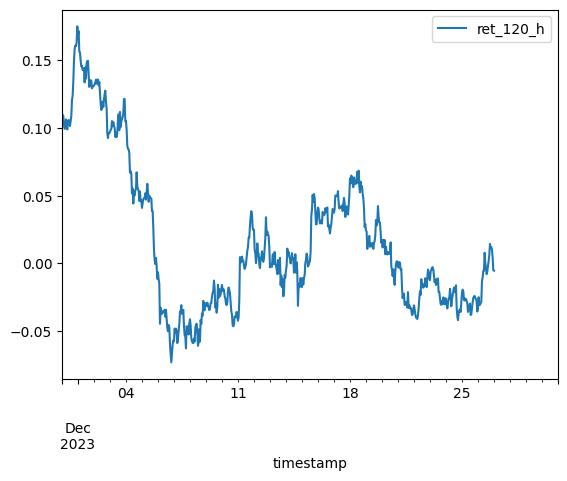

In [259]:
# create date out of 6/3/23
temp_a = pd.to_datetime('11/30/23')
temp_b = pd.to_datetime('12/31/23')

df_temp = df_btc.loc[(df_btc['timestamp'] >= temp_a) & (df_btc['timestamp'] <= temp_b)].copy()

# plot df_temp 'ret_fwd_120_h'
df_temp.plot(x='timestamp', y='ret_fwd_120_h')



In [573]:
"""

# find columns of df_merged with column name containing "senti_"
df_data = df_merged_wgt.copy()
data_cols = ['timestamp', 'ret_fwd_24_h'] + \
    [col for col in df_data.columns if 'ret_past_' in col] +\
    [col for col in df_data.columns if 'vol' in col] +\
    [col for col in df_data.columns if 'trdCnt' in col] +\
    [col for col in df_data.columns if 'senti_' in col]
# get same columns as data_cols but remove any columns that contain 'senti_'
#data_col_ = [col for col in df_data.columns if 'senti_' not in col]


data_raw = df_data[data_cols].copy()

#data_raw = data_raw.iloc[:, 0:2].copy() ################
#print(data_raw.head(1))

# make column into index
data_raw.set_index('timestamp', inplace=True)
print(data_raw.shape)

# load dataset
dataset = data_raw.copy()
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,0] = encoder.fit_transform(values[:,0])
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaled = scaler.fit_transform(values)


## PARAMS
time_steps = 24*5 #24*5 # 
n_features = data_raw.shape[1]

# frame as supervised learning
#reframed = series_to_supervised(scaled, 1, 1)
reframed = series_to_supervised(scaled, time_steps, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = int(round(data_raw.shape[0]*0.8,0)) #1500 #24*7*4*5
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = time_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential([
    layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),
                activation='relu',return_sequences=True,
                name = 'layer1'),
    layers.LSTM(25, name = 'layer2'),
    layers.Dropout(0.2),
    layers.Dense(25, activation = 'relu', name = 'dense1'),
    layers.Dense(1, activation = 'relu', name = 'output') # predict 1 output
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

#model.summary()

# callbacks #https://keras.io/examples/timeseries/timeseries_weather_forecasting/
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),
               activation='relu',return_sequences=True
               ))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu')) # predict 1 output
"""

"""path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)



# https://keras.io/api/losses/
model.compile(
    #loss='mae', 
    loss='mean_squared_error',
    optimizer='adam',
              run_eagerly=True
              #metrics=['accuracy']
              )

# fit network
history = model.fit(train_X, train_y, 
                    epochs=20, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=0, # 2 = each epoch
                    shuffle=False,
                    callbacks=[early_stopping])
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], time_steps*n_features))


# plot history
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show()

# invert scaling for forecast

inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print('y pred, unscaled:', inv_yhat[-5:-1])
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('y, unscaled:', inv_y[-5:-1])
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### compare this yhat compared to a ynaive method
# naive method is yhat = y(t-1)
yhat_naive = inv_y[:-1]
test_y_naive = inv_y[1:]
rmse_naive = math.sqrt(mean_squared_error(test_y_naive, yhat_naive))
print('test naive RMSE:', rmse_naive)

# 120 = 0.034, naiv 0.005
# 0.015 with drop out
# ret_fwd_120_h // naive yhat = y(t-1) // rsme = 0.018 
# ret_fwd_120_h // inputs: ret_fwd_120_h, senti avg // time_step = 5 days // rsme = 0.011
# ret_fwd_120_h // inputs: ret_fwd_120_h // time_step = 5 days // rsme = 0.009

## PLOT
# create one dataframe containing both yhat and test_y values
df_yhat = pd.DataFrame(yhat, columns=['yhat'])
df_y = pd.DataFrame(test_y, columns=['y'])
df_yhat_y = pd.concat([df_y, df_yhat], axis=1)
#df_yhat_y['timestamp'] = data_raw.index[-len(inv_y):]
#df_yhat_y.set_index('timestamp', inplace=True)

# plot actual vs predicted
df_yhat_y.plot()

"""


(1527, 64)
(1222, 7680) 1222 (1222,)
(1222, 120, 64) (1222,) (185, 120, 64) (185,)
